# Environment Setup

In [ ]:
# =========================
# CELL 0.1 — Mount Drive and set working directory (persistent)
# =========================
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Options Pricing Research (S26)/machine_learning_for_options_pricing_and_implied_volatility")
print("cwd =", os.getcwd())

Mounted at /content/drive
cwd = /content/drive/MyDrive/Options Pricing Research (S26)/machine_learning_for_options_pricing_and_implied_volatility


In [ ]:
# =========================
# CELL 0.2 — Installs
# QMC (Latin Hypercube)
# =========================
try:
    from scipy.stats import qmc
    import scipy
    print("scipy version:", scipy.__version__)
    print("qmc available ✅")
except Exception as e:
    print("qmc not available, upgrading scipy... error was:", repr(e))
    !pip -q install --upgrade scipy
    import scipy
    print("scipy version after upgrade:", scipy.__version__)
    from scipy.stats import qmc
    print("qmc available ✅")

scipy version: 1.16.3
qmc available ✅


In [ ]:
# =========================
# CELL 0.3 — Imports
# =========================

# Basic imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# QMC for Latin Hypercube Sampling
from scipy.stats import qmc

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, LinearLR, OneCycleLR, LambdaLR

# Utilities
import json, datetime, subprocess, os

In [ ]:
# =========================
# CELL 0.4 — Reproducibility (global seeds)
# =========================
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("SEED =", SEED)

SEED = 42


In [ ]:
# =========================
# CELL 0.5 — Run Logger (inline, saves everything to Drive under runs/)
# =========================
def _git_hash():
    try:
        return subprocess.check_output(["git", "rev-parse", "HEAD"]).decode().strip()
    except Exception:
        return "no-git"

def start_run(task: str, base_dir="runs"):
    run_id = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    run_dir = os.path.join(base_dir, task, run_id)
    fig_dir = os.path.join(run_dir, "figures")
    os.makedirs(fig_dir, exist_ok=True)

    meta = {
        "task": task,
        "run_id": run_id,
        "created_at": datetime.datetime.now().isoformat(),
        "git_commit": _git_hash(),
        "seed": SEED,
    }
    with open(os.path.join(run_dir, "meta.json"), "w") as f:
        json.dump(meta, f, indent=2)

    return run_dir, fig_dir

def save_json(run_dir: str, name: str, obj: dict):
    with open(os.path.join(run_dir, f"{name}.json"), "w") as f:
        json.dump(obj, f, indent=2)

def save_notes(run_dir: str, text: str):
    with open(os.path.join(run_dir, "notes.md"), "w") as f:
        f.write(text.strip() + "\n")

print("Logger ready ✅")

Logger ready ✅


# BS-ANN

## Closed-Form Formula

In [ ]:
# =========================
# CELL 1.0 — Week 2 START (creates a run folder for this week)
# =========================
run_dir, fig_dir = start_run("week2_bsm_basics")
print("run_dir:", run_dir)
print("fig_dir:", fig_dir)

save_json(run_dir, "params", {
    "week": 2,
    "goal": "BSM formula basics + equivalence of scaled vs unscaled + 2 plots",
    "plotA": "fix (tau,r,sigma), vary m=S/K, plot V/K",
    "plotB": "fix (m,tau,r), vary sigma, plot V/K",
})

save_notes(run_dir, """
Week 2 deliverable:
- Explain variables S,K,tau,r,sigma and what a European call payoff is.
- Explain why bs_price_call(S,K,...) and bs_moneyness_call(m=S/K,...) are equivalent.
- Plot A: V/K vs m with fixed tau,r,sigma (tau>0).
- Plot B: V/K vs sigma with fixed m,tau,r.
""")

run_dir: runs/week2_bsm_basics/20260227-153851
fig_dir: runs/week2_bsm_basics/20260227-153851/figures


In [ ]:
# =========================
# Week 2 — 1.1) BLACK–SCHOLES FORMULAE (PRICE + SCALED MONEYNESS VERSION)
# =========================

def bs_price_call(S, K, T, t, r, sigma):
  """
  Black-Sholes call option value price related to PDE (2). Returns option's price.
  S: spot price
  K: strike price
  T: time to maturity
  t: spot time
  r: interest rate
  sigma: volatility of underlying asset
  """

  # Boundary condition of Black-Sholes PDE (2)
  if T==t:
    return np.maximum(0,S-K)
  # Solution of the PDE (2) on the open interval [t, T)
  else :
    d1 = ( np.log(S / K) + (r + 0.5 * sigma ** 2) * (T-t) ) / (sigma * np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)
    value = S * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)

  return value

def bs_moyeness_call(moyeness, tau, r, sigma):
  """
  Same function as bs_price_call but in terms of moyeness. Returns V/K and
  has S/K instead of two seperate paremeters S and K.
  moyeness: S/K
  Tau: time to maturity minus spot time
  r: interest rate
  sigma: volatility of underlying asset
  """

  d1 = ( np.log(moyeness) + (r + 0.5 * sigma ** 2) * (tau) ) / (sigma * np.sqrt(tau))
  d2 = d1 - sigma*np.sqrt(tau)
  value_moyeness = moyeness * norm.cdf(d1) - np.exp(-r * (tau)) * norm.cdf(d2)

  return value_moyeness

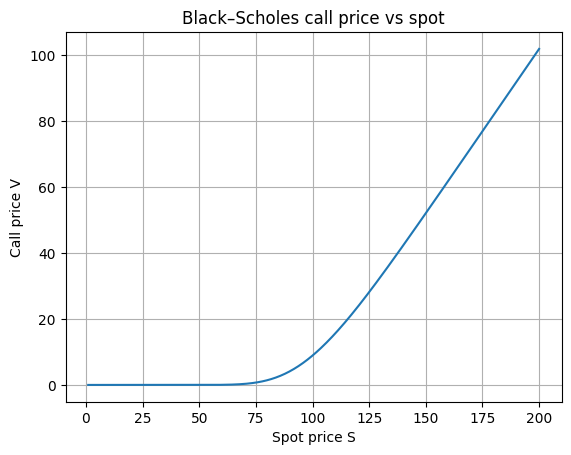

Saved: runs/week2_bsm_basics/20260227-153851/figures/plot0_price_vs_spot.png


In [ ]:
# =========================
# Week 2 — 1.2) VISUALIZATION: CALL PRICE AS A FUNCTION OF SPOT PRICE
# =========================

r, T, t, sigma, K = 0.02, 1.0, 0.0, 0.2, 100
S = np.linspace(1, 200, 400)

V = bs_price_call(S, K, T, t, r, sigma)

plt.figure()
plt.plot(S, V)
plt.xlabel("Spot price S")
plt.ylabel("Call price V")
plt.title("Black–Scholes call price vs spot")
plt.grid(True)

path = os.path.join(fig_dir, "plot0_price_vs_spot.png")
plt.savefig(path, dpi=180, bbox_inches="tight")
plt.show()

print("Saved:", path)

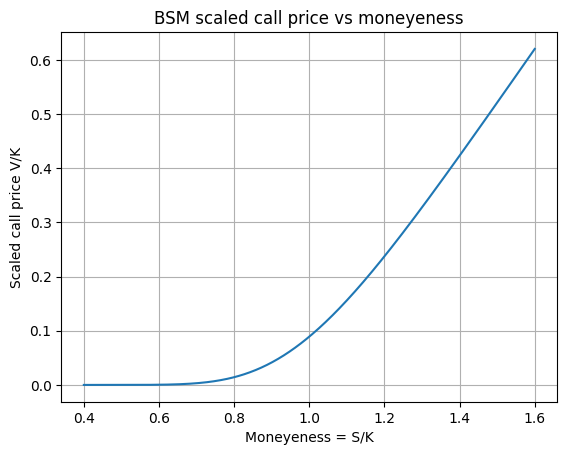

Saved: runs/week2_bsm_basics/20260227-153851/figures/plotA_VK_vs_moneyeness.png


In [ ]:
# =========================
# Week 2 — 1.3) PLOT A: SCALED CALL PRICE AS A FUNCTION OF MONEYNESS
# =========================

tau, r, sigma = 1.0, 0.02, 0.2
moneyeness = np.linspace(0.4, 1.6, 400)

vk = bs_moyeness_call(moneyeness, tau, r, sigma)

plt.figure()
plt.plot(moneyeness, vk)
plt.xlabel("Moneyeness = S/K")
plt.ylabel("Scaled call price V/K")
plt.title("BSM scaled call price vs moneyeness")
plt.grid(True)

path = os.path.join(fig_dir, "plotA_VK_vs_moneyeness.png")
plt.savefig(path, dpi=180, bbox_inches="tight")
plt.show()

print("Saved:", path)

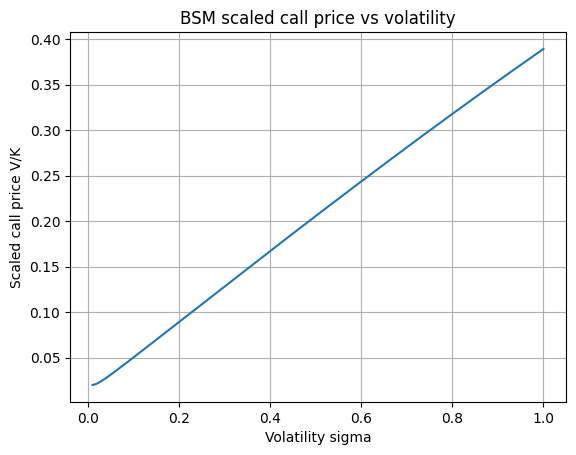

Saved: runs/week2_bsm_basics/20260227-153851/figures/plotB_VK_vs_sigma.png


In [ ]:
# =========================
# Week 2 — 1.4) PLOT B: SCALED CALL PRICE AS A FUNCTION OF VOLATILITY
# =========================

moyeness_fixed, tau, r = 1.0, 1.0, 0.02
sigmas = np.linspace(0.01, 1.0, 300)

vk2 = np.array([bs_moyeness_call(moyeness_fixed, tau, r, s) for s in sigmas])

plt.figure()
plt.plot(sigmas, vk2)
plt.xlabel("Volatility sigma")
plt.ylabel("Scaled call price V/K")
plt.title("BSM scaled call price vs volatility")
plt.grid(True)

path = os.path.join(fig_dir, "plotB_VK_vs_sigma.png")
plt.savefig(path, dpi=180, bbox_inches="tight")
plt.show()

print("Saved:", path)

In [ ]:
# =========================
# Week 2 — 1.5) EQUIVALENCE CHECK: (bs_price_call / K) == bs_moyeness_call(S/K)
# =========================

S0, K0, T0, t0, r0, sigma0 = 110, 100, 1.0, 0.0, 0.02, 0.2
tau0 = T0 - t0

vk_from_price = bs_price_call(S0, K0, T0, t0, r0, sigma0) / K0
vk_from_m = bs_moyeness_call(S0 / K0, tau0, r0, sigma0)
diff = float(abs(vk_from_price - vk_from_m))

print("V/K from bs_price_call:", float(vk_from_price))
print("V/K from bs_moyeness_call:", float(vk_from_m))
print("abs diff:", diff)

save_json(run_dir, "equivalence", {
    "inputs": {"S": S0, "K": K0, "T": T0, "t": t0, "r": r0, "sigma": sigma0},
    "vk_from_price": float(vk_from_price),
    "vk_from_m": float(vk_from_m),
    "abs_diff": diff
})

V/K from bs_price_call: 0.1560884145071418
V/K from bs_moyeness_call: 0.15608841450714184
abs diff: 2.7755575615628914e-17


In [ ]:
# =========================
# Week 2 — 1.6) WEEK 2 SUMMARY
# =========================

summary = """
Week 2 Summary (BSM basics):
I implemented the Black–Scholes European call price in two equivalent forms. The first function bs_price_call uses absolute inputs (S, K, T, t) and returns the dollar option price V. The second function bs_moyeness_call uses moyeness m=S/K and time-to-maturity tau=T−t, and returns the scaled price V/K. These are equivalent because dividing the Black–Scholes formula by K and substituting S=mK cancels K throughout, leaving a function of (m, tau, r, sigma). I verified equivalence numerically by comparing bs_price_call(S,K,T,t,r,sigma)/K to bs_moyeness_call(S/K, tau, r, sigma) on a sample input. I also generated two diagnostic plots: (1) V/K as a function of moyeness for fixed (tau, r, sigma), and (2) V/K as a function of volatility for fixed (m, tau, r).
""".strip()

with open(os.path.join(run_dir, "notes_week2_summary.md"), "w") as f:
    f.write(summary + "\n")

print("Saved summary to:", os.path.join(run_dir, "notes_week2_summary.md"))
print("\n" + summary)

Saved summary to: runs/week2_bsm_basics/20260227-153851/notes_week2_summary.md

Week 2 Summary (BSM basics):
I implemented the Black–Scholes European call price in two equivalent forms. The first function bs_price_call uses absolute inputs (S, K, T, t) and returns the dollar option price V. The second function bs_moyeness_call uses moyeness m=S/K and time-to-maturity tau=T−t, and returns the scaled price V/K. These are equivalent because dividing the Black–Scholes formula by K and substituting S=mK cancels K throughout, leaving a function of (m, tau, r, sigma). I verified equivalence numerically by comparing bs_price_call(S,K,T,t,r,sigma)/K to bs_moyeness_call(S/K, tau, r, sigma) on a sample input. I also generated two diagnostic plots: (1) V/K as a function of moyeness for fixed (tau, r, sigma), and (2) V/K as a function of volatility for fixed (m, tau, r).


## Data Generation

In [ ]:
# =========================
# CELL 3.0 — Week 3 START (creates a run folder for this week)
# =========================
run_dir, fig_dir = start_run("week3_lhs_dataset_generation")
print("run_dir:", run_dir)
print("fig_dir:", fig_dir)

save_json(run_dir, "params", {
    "week": 3,
    "goal": "LHS dataset generation for BS-ANN (X=(m,tau,r,sigma), y=V/K) + sanity checks + 4 input histograms + data card",
    "n": 10**6,
    "inputs": {
        "col0 m = S/K": [0.4, 1.6],
        "col1 tau = T-t": [0.2, 1.1],
        "col2 r": [0.02, 0.10],
        "col3 sigma": [0.01, 1.0],
    },
    "label": "col4 V/K",
    "checks": [
        "m>0, tau>0, sigma>0",
        "0 <= V/K <= m",
    ],
    "artifacts": [
        "bs_lhs_dataset_n1e6.pt",
        "week3_LHS_input_histograms.png",
        "week3_LHS_input_scatterplots.png",
        "notes_week3_data_card.md",
    ],
})

save_notes(run_dir, """
Week 3 (Feb 2–6) — LHS dataset generation (for BS-ANN)

Knowledge
- Supervised learning needs: inputs X and labels y.
- Why Latin Hypercube Sampling (LHS):
  uniform coverage across each dimension
  fewer “clumps” than random sampling
- Dataset columns:
  col0: (S/K) = m
  col1: (tau)
  col2: (r)
  col3: (sigma)
  col4: (V/K) (label)

Do
- Generate n=1e6 using bs_LHS_data_generator.
- Sanity checks:
  ensure (S/K>0), (tau>0), (sigma>0)
  check bounds: (0 <= V/K <= S/K)
- Plot histograms of each input dimension (4 histograms).
- Plot scatterplots of each pair of input dimensions (6 scatterplots).
- Friday deliverable: “data card” with ranges + histogram screenshot.
""")

run_dir: runs/week3_lhs_dataset_generation/20260209-133430
fig_dir: runs/week3_lhs_dataset_generation/20260209-133430/figures


In [ ]:
# =========================
# Week 3 — 3.1) LHS DATA GENERATOR (uses Week 2 bs_moyeness_call formula)
# =========================
def bs_LHS_data_generator(n=10**6):
    # ranges
    lo = np.array([0.4, 0.2, 0.02, 0.01])   # [m, tau, r, sigma]
    hi = np.array([1.6, 1.1, 0.10, 1.00])

    # LHS -> scale to ranges
    x = qmc.scale(qmc.LatinHypercube(d=4).random(n), lo, hi)
    m, tau, r, sigma = x[:, 0], x[:, 1], x[:, 2], x[:, 3]

    # label y = V/K (same closed-form as Week 2 bs_moyeness_call, vectorized)
    d1 = (np.log(m) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    vk = m * norm.cdf(d1) - np.exp(-r * tau) * norm.cdf(d2)

    # sanity checks
    assert np.all(m > 0), "Sanity check failed: S/K must be > 0"
    assert np.all(tau > 0), "Sanity check failed: tau must be > 0"
    assert np.all(sigma > 0), "Sanity check failed: sigma must be > 0"
    assert np.all(vk >= 0), "Sanity check failed: V/K must be >= 0"
    assert np.all(vk <= m + 1e-6), "Sanity check failed: V/K must be <= S/K"

    return torch.tensor(np.column_stack([m, tau, r, sigma, vk]), dtype=torch.float32)

In [ ]:
# =========================
# Week 3 — 3.2) GENERATE n=1e6 + SAVE DATASET
# =========================
n = 10**6
data = bs_LHS_data_generator(n)
print("Dataset shape:", tuple(data.shape))

dataset_path = os.path.join(run_dir, "bs_lhs_dataset_n1e6.pt")
torch.save(data, dataset_path)
print("Saved dataset:", dataset_path)

Dataset shape: (1000000, 5)
Saved dataset: runs/week3_lhs_dataset_generation/20260209-133430/bs_lhs_dataset_n1e6.pt


In [ ]:
# =========================
# Week 3 — 3.3) HISTOGRAMS (4 input dimensions) + SCATTERPLOTS (pairwise input dimensions) + SAVE FIGURES
# =========================

# --- Histograms ---
plt.figure(figsize=(12, 8))
input_vars = ["m = S/K", "tau", "r", "sigma"]
for i, title in enumerate(input_vars):
    plt.subplot(2, 2, i + 1)
    plt.hist(data[:, i].numpy(), bins=80)
    plt.title(title)
    plt.grid(True)

plt.suptitle("Week 3 — LHS Input Distributions (n=1e6)", fontsize=16)

hist_path = os.path.join(fig_dir, "week3_LHS_input_histograms.png")
plt.savefig(hist_path, dpi=180, bbox_inches="tight")
plt.show()
print("Saved:", hist_path)


# --- Scatterplots ---
num_input_vars = len(input_vars)
pairs = []
for i in range(num_input_vars):
    for j in range(i + 1, num_input_vars):
        pairs.append((i, j))

fig, axes = plt.subplots(3, 2, figsize=(15, 18)) # 3 rows, 2 columns for 6 plots
axes = axes.flatten() # Flatten to iterate easily

plt.suptitle("Week 3 — LHS Input Scatterplots (n=1e6)", fontsize=16, y=1.02) # Adjusted y for suptitle

for k, (idx1, idx2) in enumerate(pairs):
    ax = axes[k]
    # Use a smaller sample for scatter plots to avoid rendering too many points and make it faster
    sample_indices = np.random.choice(data.shape[0], size=min(10000, data.shape[0]), replace=False)
    ax.scatter(data[sample_indices, idx1].numpy(), data[sample_indices, idx2].numpy(), alpha=0.3, s=10) # Increased s for visibility
    ax.set_xlabel(input_vars[idx1])
    ax.set_ylabel(input_vars[idx2])
    ax.set_title(f"{input_vars[idx1]} vs {input_vars[idx2]}")
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to make space for suptitle and reduce whitespace

scatter_path = os.path.join(fig_dir, "week3_LHS_input_scatterplots.png")
plt.savefig(scatter_path, dpi=180, bbox_inches="tight")
plt.show()
print("Saved:", scatter_path)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# =========================
# Week 3 — 3.4) DATA CARD (ranges + histogram/scatterplot screenshot reference)
# =========================
mins = data.min(dim=0).values.numpy()
maxs = data.max(dim=0).values.numpy()

data_card = f"""
Week 3 Data Card — LHS Dataset (BS-ANN)

n = {n}

Target ranges:
m (S/K):      [0.4, 1.6]
tau (T-t):    [0.2, 1.1]
r:            [0.02, 0.10]
sigma:        [0.01, 1.0]

Actual min/max (generated):
m (S/K):      [{mins[0]:.6f}, {maxs[0]:.6f}]
tau (T-t):    [{mins[1]:.6f}, {maxs[1]:.6f}]
r:            [{mins[2]:.6f}, {maxs[2]:.6f}]
sigma:        [{mins[3]:.6f}, {maxs[3]:.6f}]
V/K (label):  [{mins[4]:.6f}, {maxs[4]:.6f}]

Sanity checks enforced:
- S/K > 0, tau > 0, sigma > 0
- 0 <= V/K <= S/K

Visualizations:
- {hist_path}
- {scatter_path}

Saved dataset:
- {dataset_path}
""".strip()

with open(os.path.join(run_dir, "notes_week3_data_card.md"), "w") as f:
    f.write(data_card + "\n")

print("Saved data card to:", os.path.join(run_dir, "notes_week3_data_card.md"))
print("\n" + data_card)


Saved data card to: runs/week3_lhs_dataset_generation/20260209-133430/notes_week3_data_card.md

Week 3 Data Card — LHS Dataset (BS-ANN)

n = 1000000

Target ranges:
m (S/K):      [0.4, 1.6]
tau (T-t):    [0.2, 1.1]
r:            [0.02, 0.10]
sigma:        [0.01, 1.0]

Actual min/max (generated):
m (S/K):      [0.400001, 1.600000]
tau (T-t):    [0.200001, 1.100000]
r:            [0.020000, 0.100000]
sigma:        [0.010000, 0.999999]
V/K (label):  [0.000000, 0.908450]

Sanity checks enforced:
- S/K > 0, tau > 0, sigma > 0
- 0 <= V/K <= S/K

Visualizations:
- runs/week3_lhs_dataset_generation/20260209-133430/figures/week3_LHS_input_histograms.png
- runs/week3_lhs_dataset_generation/20260209-133430/figures/week3_LHS_input_scatterplots.png

Saved dataset:
- runs/week3_lhs_dataset_generation/20260209-133430/bs_lhs_dataset_n1e6.pt


In [ ]:
# =========================
# Week 3 — 3.5) WEEK 3 SUMMARY
# =========================

summary = f"""
Week 3 Summary (LHS dataset generation for BS-ANN):
I generated a supervised-learning dataset for the Black–Scholes scaled call pricing problem, where the inputs are X = (m, tau, r, sigma) with m = S/K and the label is y = V/K. To construct X with good coverage across the 4-dimensional domain, I used Latin Hypercube Sampling (LHS), which enforces near-uniform coverage in each dimension and avoids the clumping typical of naive random sampling. Using the Week 2 closed-form scaled Black–Scholes formula, I computed V/K for each sampled point and assembled a tensor of shape (n, 5) with columns [m, tau, r, sigma, V/K]. I enforced basic domain validity checks (m>0, tau>0, sigma>0) and a no-arbitrage bound check (0 <= V/K <= m, since 0 <= V <= S). I saved the final dataset (n = {10**6}) as a PyTorch tensor, produced a 2×2 histogram figure (showing the empirical distributions of the four input dimensions), and produced a 3x2 scatterplot figure (showing the pairwise distributions of the four input dimensions); the first artifact was saved to the run folder, and the second/third artifacts were saved to the figures folder. Finally, I wrote a “data card” summarizing the target parameter ranges, realized min/max in the generated data, and a reference to the histogram/scatterplot screenshots for documentation.
""".strip()

with open(os.path.join(run_dir, "notes_week3_summary.md"), "w") as f:
    f.write(summary + "\n")

print("Saved summary to:", os.path.join(run_dir, "notes_week3_summary.md"))
print("\n" + summary)

Saved summary to: runs/week3_lhs_dataset_generation/20260209-133430/notes_week3_summary.md

Week 3 Summary (LHS dataset generation for BS-ANN):
I generated a supervised-learning dataset for the Black–Scholes scaled call pricing problem, where the inputs are X = (m, tau, r, sigma) with m = S/K and the label is y = V/K. To construct X with good coverage across the 4-dimensional domain, I used Latin Hypercube Sampling (LHS), which enforces near-uniform coverage in each dimension and avoids the clumping typical of naive random sampling. Using the Week 2 closed-form scaled Black–Scholes formula, I computed V/K for each sampled point and assembled a tensor of shape (n, 5) with columns [m, tau, r, sigma, V/K]. I enforced basic domain validity checks (m>0, tau>0, sigma>0) and a no-arbitrage bound check (0 <= V/K <= m, since 0 <= V <= S). I saved the final dataset (n = 1000000) as a PyTorch tensor, produced a 2×2 histogram figure (showing the empirical distributions of the four input dimensions

## Defining BS-ANN Class

In [ ]:
# =========================
# CELL 4.0 — Week 4 START (creates a run folder for this week)
# Goal: Paper-aligned MLP sweep + LR range test
# =========================
run_dir, fig_dir = start_run("week4_mlp_lr_search_and_paper_alignment")
print("run_dir:", run_dir)
print("fig_dir:", fig_dir)

save_json(run_dir, "params", {
    "week": 4,
    "goal": "Align with paper: (i) LR range test, (ii) MLP grid (2/3 layers × 50..500 nodes), (iii) record training time + test MSE, (iv) Figure 6.16-style plot",
    "paper_hyperparams": {
        "activation": "ReLU",
        "loss": "MSE",
        "lr_paper": 1e-5,
        "batch_size_paper": 64,
        "epochs_paper": 200,
        "device_for_timing": "cpu",
        "torch_num_threads": 1
    },
    "lr_range_test": {
        "lr_start": 1e-8,
        "lr_end": 1e-1,
        "num_iter": 400,
        "beta": 0.98,
        "divergence_factor": 4.0
    },
    "mlp_grid": {
        "layers": [2, 3],
        "nodes_per_layer": [50, 100, 150, 200, 250, 500]
    }
})

save_notes(run_dir, """
Week 4 deliverables:
1) LR Range Test (interpretable):
   - exponentially increase LR per batch
   - plot (LR vs smoothed loss)
   - choose a reasonable LR interval + suggested LR
   - save plot + json summary

2) Paper-aligned MLP sweep (Table 6.15 -> Figure 6.16):
   - 12 models: layers in {2,3}, nodes in {50,100,150,200,250,500}
   - activation ReLU, loss MSE
   - lr fixed at 1e-5, batch size 64, epochs 200
   - CPU single-thread timing
   - output: training time (hours) + test MSE for each model
   - plot Figure 6.16 style (dual-axis bars) and save artifacts
""")

print("Week 4 logger ready ✅")

run_dir: runs/week4_mlp_lr_search_and_paper_alignment/20260209-133304
fig_dir: runs/week4_mlp_lr_search_and_paper_alignment/20260209-133304/figures
Week 4 logger ready ✅


In [ ]:
# =========================
# CELL 4.1 — Paper-aligned MLP class (2 or 3 layers; 50..500 nodes)
# =========================
import time
import copy
import math
import pandas as pd

class PaperMLP(nn.Module):
    """
    Paper-aligned MLP for Black–Scholes scaled call price:
      X = (m, tau, r, sigma)  -> 4 inputs
      y = V/K                -> 1 output

    Config matches Table 6.15:
      hidden_layers: 2 or 3
      nodes per hidden layer: 50,100,150,200,250,500
      activation: ReLU
      loss: MSE
    """
    def __init__(self, hidden_layers:int, hidden_units:int, in_dim:int=4):
        super().__init__()
        assert hidden_layers in (2, 3)

        layers = []
        d = in_dim
        for _ in range(hidden_layers):
            layers.append(nn.Linear(d, hidden_units))
            layers.append(nn.ReLU())
            d = hidden_units
        layers.append(nn.Linear(d, 1))  # output V/K
        self.net = nn.Sequential(*layers)

        # Xavier init (your earlier convention)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x).squeeze(-1)  # (B,)

## Search of Optimal Learning Rate Interval

In [ ]:
# =========================
# CELL 4.2 — Data loaders (train/test split) + paper defaults
# =========================
from torch.utils.data import DataLoader, random_split

# Paper hyperparams
PAPER_LR = 1e-5
PAPER_BATCH = 64
PAPER_EPOCHS = 200

# Use CPU + single thread for paper-like training time comparisons
device = torch.device("cpu")
torch.set_num_threads(1)
print("device:", device, "| torch num threads:", torch.get_num_threads())

# Smaller dataset for quick LR test; you can increase later
bs_dataset_small = bs_LHS_data_generator(n=10**5)

# train/test split
train_frac = 0.8
n_train = int(train_frac * len(bs_dataset_small))
n_test = len(bs_dataset_small) - n_train
g = torch.Generator().manual_seed(SEED)

train_ds, test_ds = random_split(bs_dataset_small, [n_train, n_test], generator=g)

train_loader = DataLoader(train_ds, batch_size=PAPER_BATCH, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_ds,  batch_size=PAPER_BATCH, shuffle=False, drop_last=False)

print("train batches:", len(train_loader), "test batches:", len(test_loader))

device: cpu | torch num threads: 1
train batches: 1250 test batches: 313


In [ ]:
# =========================
# CELL 4.3 — LR Range Test Function Definition
# =========================
def lr_range_test(
    model,
    train_loader,
    device,
    lr_start=1e-8,
    lr_end=1e-1,
    num_iter=400,
    beta=0.98,
    divergence_factor=4.0
):
    """
    LR Range Test:
      - start lr_start
      - multiply LR each iteration so we reach lr_end at num_iter
      - record smoothed loss
      - stop early if loss diverges
    Returns: lrs, losses
    """
    model = model.to(device)
    model.train()
    # save weights so test doesn't permanently change model
    init_state = copy.deepcopy(model.state_dict())
    optimizer = optim.Adam(model.parameters(), lr=lr_start)
    mult = (lr_end / lr_start) ** (1 / max(num_iter - 1, 1))
    avg_loss = 0.0
    best_loss = float("inf")
    lrs, losses = [], []
    it = 0
    loader_iter = iter(train_loader)
    while it < num_iter:
        try:
            batch = next(loader_iter)
        except StopIteration:
            loader_iter = iter(train_loader)
            batch = next(loader_iter)
        batch = batch.to(device)
        X = batch[:, :-1]
        y = batch[:, -1]
        lr = optimizer.param_groups[0]["lr"]
        lrs.append(lr)
        optimizer.zero_grad(set_to_none=True)
        yhat = model(X)
        loss = F.mse_loss(yhat, y)
        loss_val = loss.item()
        # smooth
        avg_loss = beta * avg_loss + (1 - beta) * loss_val
        smooth = avg_loss / (1 - beta ** (it + 1))
        losses.append(smooth)
        if smooth < best_loss:
            best_loss = smooth
        if smooth > divergence_factor * best_loss:
            print(f"Stopping early at iter={it}, lr={lr:.3e}, smooth_loss={smooth:.3e} (diverged)")
            break
        loss.backward()
        optimizer.step()
        optimizer.param_groups[0]["lr"] = lr * mult
        it += 1
    # restore weights
    model.load_state_dict(init_state)
    return lrs, losses

print("lr_range_test function defined ✅")

lr_range_test function defined ✅


Running LR Range Test for 12 model configurations...
Testing: 2-layer MLP with 50 nodes per layer
  → lr_high: 4.833e-02, lr_suggest: 4.833e-03

Testing: 2-layer MLP with 100 nodes per layer
  → lr_high: 4.458e-02, lr_suggest: 4.458e-03

Testing: 2-layer MLP with 150 nodes per layer
  → lr_high: 2.243e-02, lr_suggest: 2.243e-03

Testing: 2-layer MLP with 200 nodes per layer
  → lr_high: 2.336e-02, lr_suggest: 2.336e-03

Testing: 2-layer MLP with 250 nodes per layer
  → lr_high: 2.336e-02, lr_suggest: 2.336e-03

Testing: 2-layer MLP with 500 nodes per layer
Stopping early at iter=376, lr=3.949e-02, smooth_loss=4.754e-02 (diverged)
  → lr_high: 1.987e-02, lr_suggest: 1.987e-03

Testing: 3-layer MLP with 50 nodes per layer
  → lr_high: 1.000e-01, lr_suggest: 1.000e-02

Testing: 3-layer MLP with 100 nodes per layer
  → lr_high: 1.760e-02, lr_suggest: 1.760e-03

Testing: 3-layer MLP with 150 nodes per layer
  → lr_high: 1.175e-02, lr_suggest: 1.175e-03

Testing: 3-layer MLP with 200 nodes p

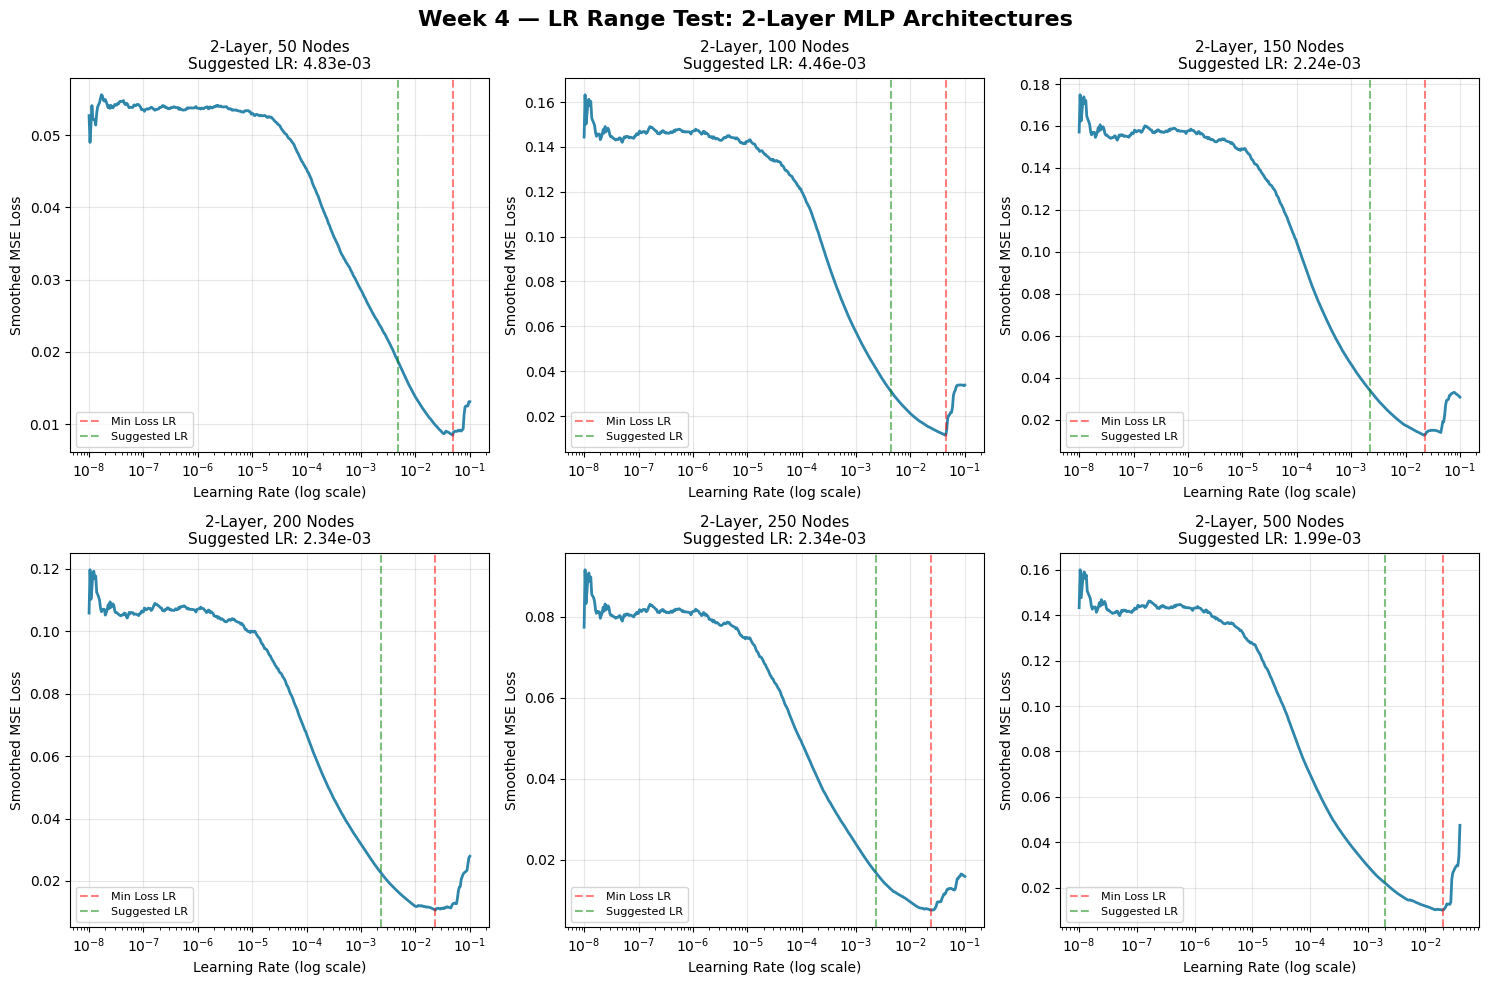

Saved: runs/week4_mlp_lr_search_and_paper_alignment/20260206-023609/figures/week4_lr_range_test_2layer_grid.png


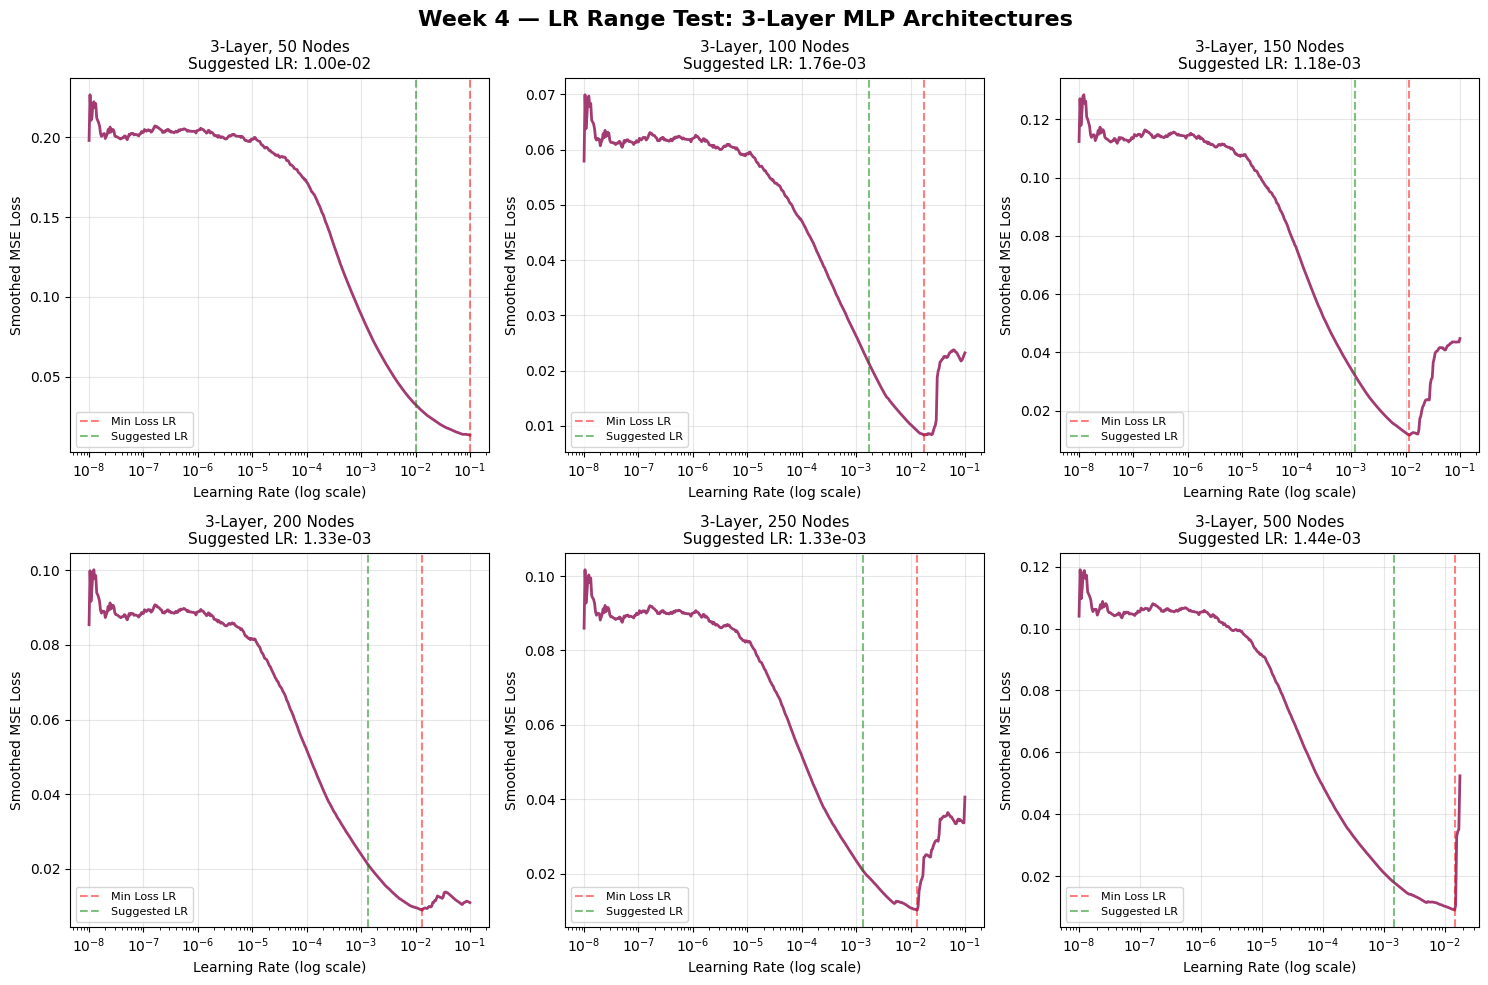

Saved: runs/week4_mlp_lr_search_and_paper_alignment/20260206-023609/figures/week4_lr_range_test_3layer_grid.png

LR Range Test Grid Summary:
 layers  nodes  lr_high_min_loss  lr_suggest
      2     50          0.048329    0.004833
      2    100          0.044578    0.004458
      2    150          0.022432    0.002243
      2    200          0.023357    0.002336
      2    250          0.023357    0.002336
      2    500          0.019872    0.001987
      3     50          0.100000    0.010000
      3    100          0.017604    0.001760
      3    150          0.011754    0.001175
      3    200          0.013268    0.001327
      3    250          0.013268    0.001327
      3    500          0.014384    0.001438

All LR range test artifacts saved ✅


In [ ]:
# =========================
# CELL 4.4 — LR Range Test Grid (12 configurations: 2×6 + 3×6)
# =========================

# Define grid: layers × nodes
lr_grid_layers = [2, 3]
lr_grid_nodes = [50, 100, 150, 200, 250, 500]

# Storage for all results
lr_test_results = []

print("Running LR Range Test for 12 model configurations...")
print("="*60)

for n_layers in lr_grid_layers:
    for n_nodes in lr_grid_nodes:
        print(f"Testing: {n_layers}-layer MLP with {n_nodes} nodes per layer")

        # Set seed for reproducibility (ensures same batches across runs)
        torch.manual_seed(SEED)
        np.random.seed(SEED)

        # Recreate train_loader with same seed to ensure identical batch order
        g = torch.Generator().manual_seed(SEED)
        train_ds_temp, _ = random_split(bs_dataset_small, [n_train, n_test], generator=g)
        train_loader_temp = DataLoader(train_ds_temp, batch_size=PAPER_BATCH, shuffle=True,
                                       drop_last=True, generator=g)

        # Create model
        lr_model = PaperMLP(hidden_layers=n_layers, hidden_units=n_nodes).to(device)

        # Run LR test
        lrs, losses = lr_range_test(
            lr_model,
            train_loader_temp,
            device=device,
            lr_start=1e-8,
            lr_end=1e-1,
            num_iter=400,
            beta=0.98,
            divergence_factor=4.0
        )

        # Find optimal LR
        min_i = int(np.argmin(losses))
        lr_high = float(lrs[min_i])
        lr_suggest = lr_high / 10.0

        # Store results
        lr_test_results.append({
            "layers": n_layers,
            "nodes": n_nodes,
            "lrs": lrs,
            "losses": losses,
            "lr_high": lr_high,
            "lr_suggest": lr_suggest
        })

        print(f"  → lr_high: {lr_high:.3e}, lr_suggest: {lr_suggest:.3e}")
        print()

print("LR Range Test Grid Complete ✅")
print("="*60)

# =========================
# Plot 1: 2-layer architectures
# =========================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Week 4 — LR Range Test: 2-Layer MLP Architectures", fontsize=16, fontweight='bold')

for idx, n_nodes in enumerate(lr_grid_nodes):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    # Find corresponding result
    result = next(r for r in lr_test_results if r["layers"] == 2 and r["nodes"] == n_nodes)

    ax.plot(result["lrs"], result["losses"], linewidth=2, color='#2E86AB')
    ax.set_xscale("log")
    ax.set_xlabel("Learning Rate (log scale)", fontsize=10)
    ax.set_ylabel("Smoothed MSE Loss", fontsize=10)
    ax.set_title(f"2-Layer, {n_nodes} Nodes\nSuggested LR: {result['lr_suggest']:.2e}", fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.axvline(result["lr_high"], color='red', linestyle='--', alpha=0.5, label=f'Min Loss LR')
    ax.axvline(result["lr_suggest"], color='green', linestyle='--', alpha=0.5, label=f'Suggested LR')
    ax.legend(fontsize=8)

plt.tight_layout()
lr_plot_2layer_path = os.path.join(fig_dir, "week4_lr_range_test_2layer_grid.png")
plt.savefig(lr_plot_2layer_path, dpi=180, bbox_inches="tight")
plt.show()
print("Saved:", lr_plot_2layer_path)

# =========================
# Plot 2: 3-layer architectures
# =========================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Week 4 — LR Range Test: 3-Layer MLP Architectures", fontsize=16, fontweight='bold')

for idx, n_nodes in enumerate(lr_grid_nodes):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    # Find corresponding result
    result = next(r for r in lr_test_results if r["layers"] == 3 and r["nodes"] == n_nodes)

    ax.plot(result["lrs"], result["losses"], linewidth=2, color='#A23B72')
    ax.set_xscale("log")
    ax.set_xlabel("Learning Rate (log scale)", fontsize=10)
    ax.set_ylabel("Smoothed MSE Loss", fontsize=10)
    ax.set_title(f"3-Layer, {n_nodes} Nodes\nSuggested LR: {result['lr_suggest']:.2e}", fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.axvline(result["lr_high"], color='red', linestyle='--', alpha=0.5, label=f'Min Loss LR')
    ax.axvline(result["lr_suggest"], color='green', linestyle='--', alpha=0.5, label=f'Suggested LR')
    ax.legend(fontsize=8)

plt.tight_layout()
lr_plot_3layer_path = os.path.join(fig_dir, "week4_lr_range_test_3layer_grid.png")
plt.savefig(lr_plot_3layer_path, dpi=180, bbox_inches="tight")
plt.show()
print("Saved:", lr_plot_3layer_path)

# =========================
# Save summary JSON
# =========================
summary_data = []
for result in lr_test_results:
    summary_data.append({
        "layers": result["layers"],
        "nodes": result["nodes"],
        "lr_high_min_loss": result["lr_high"],
        "lr_suggest": result["lr_suggest"]
    })

save_json(run_dir, "lr_range_test_grid_summary", {
    "configurations": summary_data,
    "note": "LR range test performed on all 12 paper-aligned architectures. Paper uses lr=1e-5 for final training.",
    "test_params": {
        "lr_start": 1e-8,
        "lr_end": 1e-1,
        "num_iter": 400,
        "beta": 0.98,
        "divergence_factor": 4.0
    }
})

print("\nLR Range Test Grid Summary:")
df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))
print("\nAll LR range test artifacts saved ✅")

## Training BS-ANN

In [ ]:
# =========================
# CELL 4.4 — Train/eval helpers for paper sweep (MSE + training time)
# =========================

import time, os, glob

@torch.no_grad()
def eval_mse(model, loader, device):
    """Return average MSE over loader."""
    model.eval()
    sse = 0.0
    n = 0
    for batch in loader:
        batch = batch.to(device)
        X = batch[:, :-1]
        y = batch[:, -1]
        yhat = model(X)
        sse += F.mse_loss(yhat, y, reduction="sum").item()
        n += X.size(0)
    return sse / max(n, 1)


def find_latest_checkpoint(task_dir: str, tag: str):
    """
    Search for the newest checkpoint_{tag}.pt under:
      {task_dir}/*/checkpoint_{tag}.pt

    task_dir should match CELL 4.0 task folder:
      base_dir / task
    e.g. task_dir = "runs/week4_mlp_lr_search_and_paper_alignment"

    Returns:
      (ckpt_path, run_dir) or (None, None) if not found
    """
    pattern = os.path.join(task_dir, "*", f"checkpoint_{tag}.pt")
    matches = glob.glob(pattern)
    if not matches:
        return None, None

    # newest by modification time
    ckpt_path = max(matches, key=os.path.getmtime)
    run_dir = os.path.dirname(ckpt_path)
    return ckpt_path, run_dir


def train_fixed_epochs(
    model,
    train_loader,
    test_loader,
    device,
    lr,
    epochs=200,
    log_every=50,
    # --- Week 4 / CELL 4.0 alignment ---
    run_dir=None,          # default: use current run_dir from CELL 4.0
    fig_dir=None,          # default: use current fig_dir from CELL 4.0
    tag="model",           # e.g., "2L_50N"
    save_artifacts=True,
    checkpoint_every=1,    # ✅ safest
    resume=True,
    # --- NEW: auto-resume across old run folders ---
    auto_find_checkpoint=True,
    task_dir="runs/week4_mlp_lr_search_and_paper_alignment"  # matches CELL 4.0 task name
):

    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    # Ensure fig_dir exists if provided
    if fig_dir is not None:
        os.makedirs(fig_dir, exist_ok=True)

    # -------- Determine checkpoint path to use --------
    ckpt_path = os.path.join(run_dir, f"checkpoint_{tag}.pt") if run_dir is not None else None

    # If no checkpoint in current run_dir, optionally auto-find the latest one across task_dir
    if resume and save_artifacts and auto_find_checkpoint:
        needs_search = (ckpt_path is None) or (not os.path.exists(ckpt_path))
        if needs_search:
            found_ckpt, found_run = find_latest_checkpoint(task_dir=task_dir, tag=tag)
            if found_ckpt is not None:
                print("🔎 Found existing checkpoint in an older run folder:")
                print("   ", found_ckpt)
                # Switch run_dir/fig_dir to the folder containing the checkpoint
                run_dir = found_run
                fig_dir = os.path.join(run_dir, "figures")
                os.makedirs(fig_dir, exist_ok=True)
                ckpt_path = found_ckpt

    # Now define paths based on (possibly updated) run_dir
    ckpt_path = os.path.join(run_dir, f"checkpoint_{tag}.pt") if run_dir is not None else None
    best_path = os.path.join(run_dir, f"model_best_{tag}.pt") if run_dir is not None else None

    # ---- Resume state ----
    start_epoch = 1
    train_hist, test_hist = [], []
    best_test = float("inf")

    if resume and save_artifacts and ckpt_path is not None and os.path.exists(ckpt_path):
        ckpt = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(ckpt["model_state"])
        opt.load_state_dict(ckpt["opt_state"])
        start_epoch = int(ckpt["epoch"]) + 1
        train_hist = list(ckpt.get("train_curve", []))
        test_hist  = list(ckpt.get("test_curve", []))
        best_test  = float(ckpt.get("best_test_mse", float("inf")))
        print(f"✅ Resumed from checkpoint: {ckpt_path}")
        print(f"   last completed epoch = {ckpt['epoch']}  -> continuing at epoch {start_epoch}")
    else:
        if save_artifacts:
            print("ℹ️ No checkpoint found — training from scratch.")
            if run_dir is not None:
                print("   saving to:", run_dir)

    # ---- Training loop ----
    t0 = time.perf_counter()

    for ep in range(start_epoch, epochs + 1):
        model.train()
        for batch in train_loader:
            batch = batch.to(device)
            X = batch[:, :-1]
            y = batch[:, -1]

            opt.zero_grad(set_to_none=True)
            yhat = model(X)
            loss = F.mse_loss(yhat, y)
            loss.backward()
            opt.step()

        train_m = float(eval_mse(model, train_loader, device))
        test_m  = float(eval_mse(model, test_loader, device))
        train_hist.append(train_m)
        test_hist.append(test_m)

        # best weights
        if test_m < best_test:
            best_test = test_m
            if save_artifacts and best_path is not None:
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                torch.save(best_state, best_path)
                print(f"⭐ New best test MSE={best_test:.3e} at epoch {ep} -> saved {best_path}")

        # logging (screen only)
        if ep % log_every == 0 or ep in (1, epochs):
            print(f"epoch {ep:3d}/{epochs} | train MSE={train_m:.3e} | test MSE={test_m:.3e}")

        # checkpoint (OVERWRITES SAME FILE)
        if save_artifacts and ckpt_path is not None and (ep % checkpoint_every == 0):
            ckpt = {
                "epoch": int(ep),
                "model_state": {k: v.detach().cpu().clone() for k, v in model.state_dict().items()},
                "opt_state": opt.state_dict(),
                "train_curve": [float(x) for x in train_hist],
                "test_curve":  [float(x) for x in test_hist],
                "best_test_mse": float(best_test),
                "lr": float(lr),
                "epochs": int(epochs),
                "tag": str(tag),
                "seed": int(SEED),
            }
            torch.save(ckpt, ckpt_path)

            # progress snapshot (overwritten)
            if run_dir is not None:
                save_json(run_dir, f"metrics_progress_{tag}", {
                    "epoch": int(ep),
                    "train_mse": float(train_m),
                    "test_mse": float(test_m),
                    "best_test_mse": float(best_test),
                    "lr": float(lr),
                    "tag": str(tag),
                })

    t1 = time.perf_counter()
    seconds = float(t1 - t0)

    out = {
      "lr": float(lr),
      "epochs": int(epochs),

      # --- timing (match what Cell 4.5 expects) ---
      "train_seconds": seconds,
      "train_hours": float(seconds / 3600.0),

      # --- final metrics ---
      "train_mse_final": float(train_hist[-1]) if len(train_hist) else None,
      "test_mse_final": float(test_hist[-1]) if len(test_hist) else None,
      "best_test_mse": float(best_test),

      # --- curves ---
      "train_curve": [float(x) for x in train_hist],
      "test_curve": [float(x) for x in test_hist],

      # --- bookkeeping ---
      "tag": str(tag),
      "device": str(device),
      "torch_num_threads": int(torch.get_num_threads()),
      "start_epoch_used": int(start_epoch),
      "completed_epochs_total": int(len(train_hist)),
      "checkpoint_path": ckpt_path,
      "best_model_path": best_path,
      "run_dir_used": run_dir,
      "fig_dir_used": fig_dir,
    }

    # final summary + plot
    if save_artifacts and run_dir is not None:
        save_json(run_dir, f"metrics_{tag}", out)

        if fig_dir is not None:
            os.makedirs(fig_dir, exist_ok=True)
            plt.figure(figsize=(8, 5))
            plt.plot(train_hist, label="train MSE")
            plt.plot(test_hist, label="test MSE")
            plt.xlabel("Epoch")
            plt.ylabel("MSE")
            plt.title(f"Train/Test MSE vs Epoch ({tag})")
            plt.grid(True)
            plt.legend()
            curve_path = os.path.join(fig_dir, f"mse_curves_{tag}.png")
            plt.savefig(curve_path, dpi=180, bbox_inches="tight")
            plt.show()
            print("Saved:", curve_path)

    return out

In [ ]:
# =========================
# CELL 4.5 — Paper-aligned 12-model sweep (Table 6.15 -> Figure 6.16 data)
# Enhanced to load existing results if already complete, otherwise trains/resumes.
# =========================

# Ensure run_dir and fig_dir are defined from the previous step's execution
# (Expected to be set by running the 'Set Existing Run Context' cell, e.g., 74a964d9)
import json
import os
import pandas as pd

print(f"Using run_dir: {run_dir}")

layers_list = [2, 3]
nodes_list  = [50, 100, 150, 200, 250, 500]

# Generate all expected tags to check for full completion
all_tags = []
for H in nodes_list:
    for L in layers_list:
        all_tags.append(f"{L}L_{H}N")

all_models_finished = True
for tag in all_tags:
    final_path = os.path.join(run_dir, f"metrics_{tag}.json")
    if not os.path.exists(final_path):
        all_models_finished = False
        break

results = []

if all_models_finished:
    print("All models previously trained. Loading existing results...")
    for tag in all_tags: # Iterate through all tags to load their json
        filepath = os.path.join(run_dir, f"metrics_{tag}.json")
        try:
            with open(filepath, 'r') as f:
                data = json.load(f)
            parts = tag.split('_')
            L = int(parts[0][:-1])
            H = int(parts[1][:-1])

            results.append({
                "label": f"{L} layers {H} nodes",
                "layers": L,
                "nodes": H,
                "tag": tag,
                "train_hours": data.get("train_hours"),
                "test_mse": data.get("test_mse_final"),
                "train_mse": data.get("train_mse_final"),
                "train_curve": data.get("train_curve"),
                "test_curve": data.get("test_curve"),
            })
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
else:
    print("Some models are incomplete or need training. Proceeding with training/resume logic...")
    # IMPORTANT: for timing comparability, keep CPU single thread (already set)
    # Also: for paper alignment, fix lr=1e-5, batch=64, epochs=200
    for H in nodes_list:
        for L in layers_list:  # order: 2-layer then 3-layer for each H (matches paper axis style)
            label = f"{L} layers {H} nodes"
            print("\n====", label, "====")

            model = PaperMLP(hidden_layers=L, hidden_units=H)

            tag = f"{L}L_{H}N"  # unique per model, e.g., "2L_50N"

            final_path = os.path.join(run_dir, f"metrics_{tag}.json")

            # If the final metrics file exists, this model already finished; skip its training.
            if os.path.exists(final_path):
                print(f"✅ Skipping {tag} (already finished): {final_path}")
                # Load the data for this already finished model and add to results
                try:
                    with open(final_path, 'r') as f:
                        data = json.load(f)
                    results.append({
                        "label": label,
                        "layers": L,
                        "nodes": H,
                        "tag": tag,
                        "train_hours": data.get("train_hours"),
                        "test_mse": data.get("test_mse_final"),
                        "train_mse": data.get("train_mse_final"),
                        "train_curve": data.get("train_curve"),
                        "test_curve": data.get("test_curve"),
                    })
                except Exception as e:
                    print(f"Error loading {final_path} for skipped model: {e}")
                continue # Skip calling train_fixed_epochs if already finished


            out = train_fixed_epochs(
                model,
                train_loader,
                test_loader,
                device=device,
                lr=PAPER_LR,
                epochs=PAPER_EPOCHS,
                log_every=50,
                run_dir=run_dir,             # ✅ save into this Week 4 run folder
                fig_dir=fig_dir,             # ✅ save curves into this figures folder
                tag=tag,                     # ✅ makes checkpoint filenames unique per model
                checkpoint_every=1,          # ✅ safest (writes one rolling checkpoint file)
                resume=True,                 # ✅ resume if notebook crashes mid-model
                auto_find_checkpoint=False   # ✅ DO NOT mix with older runs during sweep
            )

            results.append({
            "label": label,
            "layers": L,
            "nodes": H,
            "tag": tag,
            "train_hours": out["train_hours"],
            "test_mse": out["test_mse_final"],
            "train_mse": out["train_mse_final"],
            "train_curve": out["train_curve"],
            "test_curve": out["test_curve"],
            })

df = pd.DataFrame(results)

# Save raw results (without huge curves) as json summary
save_json(run_dir, "paper_sweep_summary", {
    "lr": PAPER_LR, # These global variables should be available from CELL 4.2
    "batch": PAPER_BATCH, # from CELL 4.2
    "epochs": PAPER_EPOCHS, # from CELL 4.2
    "device": str(device), # from CELL 4.2
    "torch_num_threads": int(torch.get_num_threads()), # from CELL 4.2
    "rows": [
        {"label": r["label"], "layers": int(r["layers"]), "nodes": int(r["nodes"]),
         "train_hours": float(r["train_hours"]), "test_mse": float(r["test_mse"])}
        for _, r in df.iterrows()
    ]
})

# Also save full dataframe as CSV (includes curves? keep it small: drop curves)
df_small = df.drop(columns=["train_curve", "test_curve"])
csv_path = os.path.join(run_dir, "week4_paper_mlp_sweep.csv")
df_small.to_csv(csv_path, index=False)
print("Saved:", csv_path)

display(df_small)

Using run_dir: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223
All models previously trained. Loading existing results...
Saved: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/week4_paper_mlp_sweep.csv


,label,layers,nodes,tag,train_hours,test_mse,train_mse
0,2 layers 50 nodes,2,50,2L_50N,0.123940,2.789249e-06,2.767186e-06
1,3 layers 50 nodes,3,50,3L_50N,0.141425,2.308291e-06,2.282548e-06
2,2 layers 100 nodes,2,100,2L_100N,0.135535,8.719681e-07,8.516561e-07
3,3 layers 100 nodes,3,100,3L_100N,0.164692,5.470124e-07,5.238315e-07
4,2 layers 150 nodes,2,150,2L_150N,0.157170,4.445163e-07,4.324675e-07
5,3 layers 150 nodes,3,150,3L_150N,0.201700,3.833236e-07,3.664263e-07
6,2 layers 200 nodes,2,200,2L_200N,0.168198,2.287168e-07,2.151874e-07
7,3 layers 200 nodes,3,200,3L_200N,0.238827,1.826171e-07,1.704996e-07
8,2 layers 250 nodes,2,250,2L_250N,0.200454,1.949413e-07,1.865344e-07
9,3 layers 250 nodes,3,250,3L_250N,0.317977,5.378618e-07,5.226418e-07


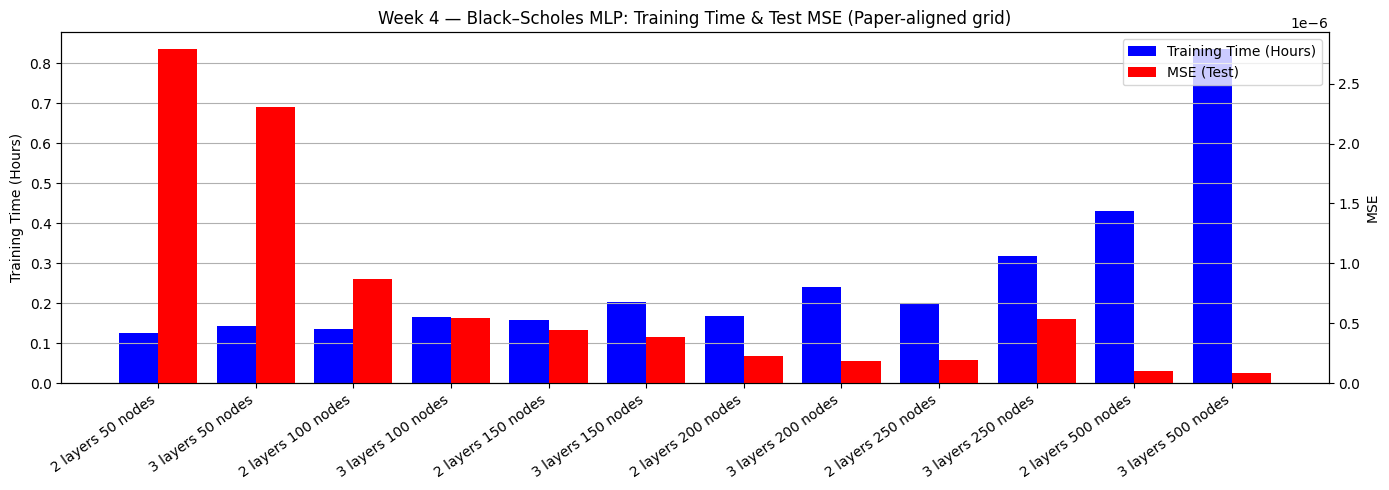

Saved: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/figures/week4_fig6_16_style_time_vs_mse.png


In [ ]:
# =========================
# CELL 4.6 — Two-sided bar chart (Figure 6.16 in paper)
# =========================
labels = df["label"].tolist()
x = np.arange(len(labels))

train_hours = df["train_hours"].values
test_mse = df["test_mse"].values

fig, ax1 = plt.subplots(figsize=(14, 5))
ax2 = ax1.twinx()

bar_w = 0.40
ax1.bar(x - bar_w/2, train_hours, width=bar_w, label="Training Time (Hours)", color='blue')
ax2.bar(x + bar_w/2, test_mse,    width=bar_w, label="MSE (Test)", color='red')

ax1.set_ylabel("Training Time (Hours)")
ax2.set_ylabel("MSE")
ax1.set_title("Week 4 — Black–Scholes MLP: Training Time & Test MSE (Paper-aligned grid)")
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=35, ha="right")
ax1.grid(True, axis="y")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc="upper right") # Changed legend location to 'upper right'

plt.tight_layout()

fig_path = os.path.join(fig_dir, "week4_fig6_16_style_time_vs_mse.png")
plt.savefig(fig_path, dpi=180, bbox_inches="tight")
plt.show()

print("Saved:", fig_path)

Saved: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/figures/week4_train_curves_2layer_50_250_500.png


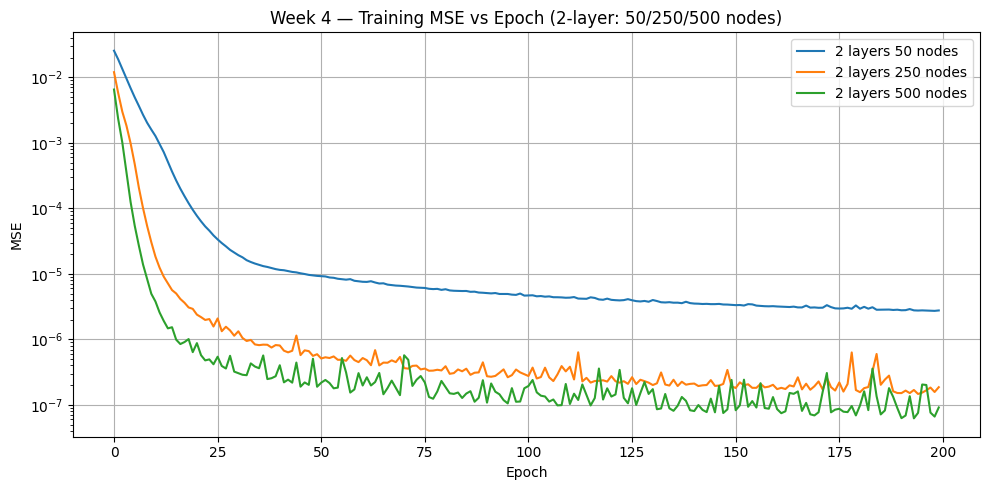

Saved: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/figures/week4_test_curves_2layer_50_250_500.png


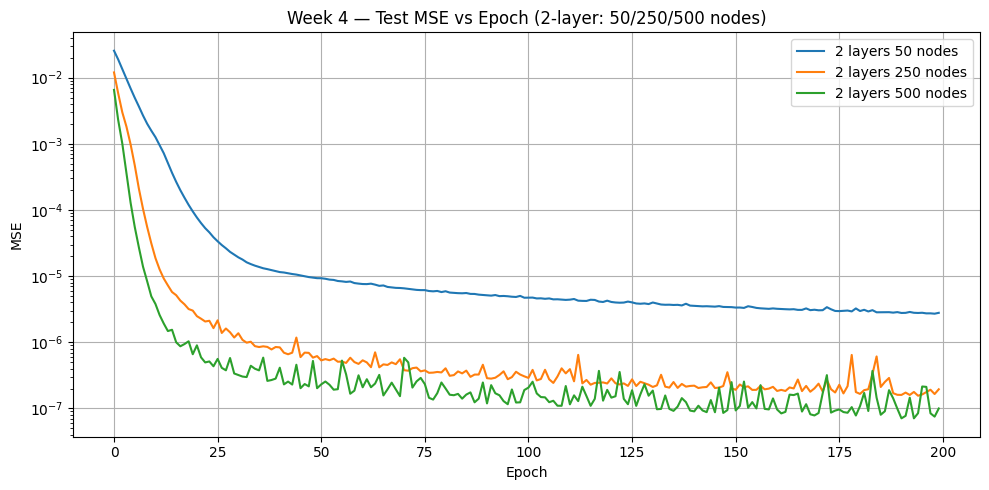

Saved: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/figures/week4_train_curves_3layer_50_250_500.png


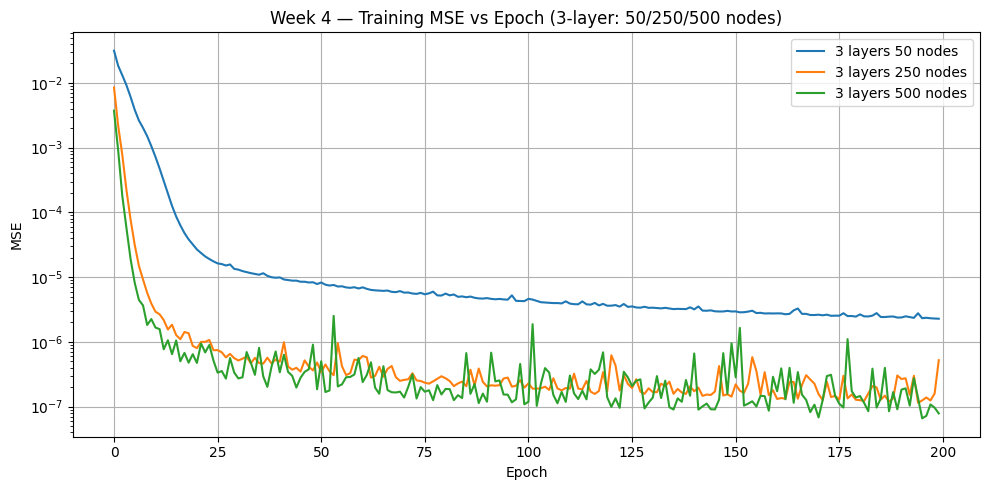

Saved: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/figures/week4_test_curves_3layer_50_250_500.png


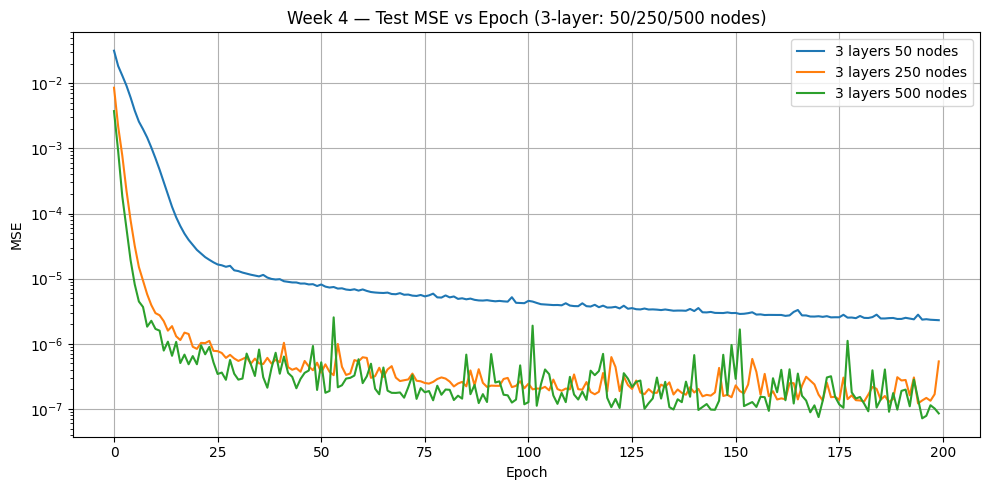

In [ ]:
# =========================
# CELL 4.7 — MSE Loss vs epochs for train/test data
# =========================
def plot_curves(df, configs, which="train_curve", title="", yscale='linear', save_path=None):
    plt.figure(figsize=(10, 5))
    for (L, H) in configs:
        row = df[(df.layers == L) & (df.nodes == H)].iloc[0]
        plt.plot(row[which], label=f"{L} layers {H} nodes")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    if yscale == 'log':
        plt.yscale('log')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=180, bbox_inches="tight")
        print("Saved:", save_path)
    plt.show()

# --- 2-layer network plots ---
configs_2layer = [(2, 50), (2, 250), (2, 500)]

# Plot and save Training MSE curves with logarithmic y-scale
train_curve_path_2layer = os.path.join(fig_dir, "week4_train_curves_2layer_50_250_500.png")
plot_curves(df, configs_2layer, which="train_curve",
            title="Week 4 — Training MSE vs Epoch (2-layer: 50/250/500 nodes)",
            yscale='log', save_path=train_curve_path_2layer)

# Plot and save Test MSE curves with logarithmic y-scale
test_curve_path_2layer = os.path.join(fig_dir, "week4_test_curves_2layer_50_250_500.png")
plot_curves(df, configs_2layer, which="test_curve",
            title="Week 4 — Test MSE vs Epoch (2-layer: 50/250/500 nodes)",
            yscale='log', save_path=test_curve_path_2layer)

# --- 3-layer network plots ---
configs_3layer = [(3, 50), (3, 250), (3, 500)]

# Plot and save Training MSE curves for 3-layer networks
train_curve_path_3layer = os.path.join(fig_dir, "week4_train_curves_3layer_50_250_500.png")
plot_curves(df, configs_3layer, which="train_curve",
            title="Week 4 — Training MSE vs Epoch (3-layer: 50/250/500 nodes)",
            yscale='log', save_path=train_curve_path_3layer)

# Plot and save Test MSE curves for 3-layer networks
test_curve_path_3layer = os.path.join(fig_dir, "week4_test_curves_3layer_50_250_500.png")
plot_curves(df, configs_3layer, which="test_curve",
            title="Week 4 — Test MSE vs Epoch (3-layer: 50/250/500 nodes)",
            yscale='log', save_path=test_curve_path_3layer)


In [ ]:
# =========================
# CELL 4.8 — Week 4 Summary Notes (saved to run folder)
# =========================
summary = f"""
Week 4 Summary (Paper alignment: MLP + LR search):

(1) LR Range Test:
- Ran an exponential LR range test on a small paper-aligned model (2 layers, 50 nodes).
- Saved LR-vs-loss plot: {os.path.join(fig_dir, "week4_lr_range_test.png")}
- Suggested LR from min-loss heuristic (for intuition), but for strict paper replication we fix lr = 1e-5.

(2) Paper-aligned MLP sweep (Table 6.15 grid):
- Trained 12 networks: layers in {{2,3}} × nodes in {{50,100,150,200,250,500}}
- Activation: ReLU | Loss: MSE | Epochs: {PAPER_EPOCHS} | Batch: {PAPER_BATCH} | LR: {PAPER_LR}
- Timing setup: CPU with torch.set_num_threads(1) for comparability
- Saved CSV: {os.path.join(run_dir, "week4_paper_mlp_sweep.csv")}
- Saved Figure 6.16-style plot: {os.path.join(fig_dir, "week4_fig6_16_style_time_vs_mse.png")}

(3) Optional curves:
- Plotted train/test MSE vs epoch for 2-layer networks with 50/250/500 nodes to mirror the paper’s discussion.
""".strip()

with open(os.path.join(run_dir, "notes_week4_summary.md"), "w") as f:
    f.write(summary + "\n")

print("Saved summary to:", os.path.join(run_dir, "notes_week4_summary.md"))
print("\n" + summary)

Saved summary to: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/notes_week4_summary.md

Week 4 Summary (Paper alignment: MLP + LR search):

(1) LR Range Test:
- Ran an exponential LR range test on a small paper-aligned model (2 layers, 50 nodes).
- Saved LR-vs-loss plot: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/figures/week4_lr_range_test.png
- Suggested LR from min-loss heuristic (for intuition), but for strict paper replication we fix lr = 1e-5.

(2) Paper-aligned MLP sweep (Table 6.15 grid):
- Trained 12 networks: layers in {2,3} × nodes in {50,100,150,200,250,500}
- Activation: ReLU | Loss: MSE | Epochs: 200 | Batch: 64 | LR: 1e-05
- Timing setup: CPU with torch.set_num_threads(1) for comparability
- Saved CSV: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/week4_paper_mlp_sweep.csv
- Saved Figure 6.16-style plot: runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/figures/week4_fig6_16_style_time_vs_mse.png

(3) Optional cu

## Training BS-ANN (Full Dataset)

In [ ]:
# =========================
# CELL 5.0 — Week 5 START (creates a run folder for this week)
# =========================
run_dir_full, fig_dir_full = start_run("week5_full_dataset_4_models_sweep")
print("run_dir_full:", run_dir_full)
print("fig_dir_full:", fig_dir_full)

save_json(run_dir_full, "params", {
    "week": 5,
    "goal": "Train 4 paper-aligned models on the full 1M dataset, compare results to 100k dataset",
    "paper_hyperparams": {
        "activation": "ReLU",
        "loss": "MSE",
        "lr_paper": 1e-5,
        "batch_size_paper": 64,
        "epochs_paper": 200,
        "device_for_timing": "cpu",
        "torch_num_threads": 1
    },
    "mlp_grid_subset": {
        "layers": [2, 3],
        "nodes_per_layer": [50, 100]
    }
})

save_notes(run_dir_full, """
Week 5 deliverable:
- Load the full 1 million data points dataset.
- Train the four "best" models from the paper's configurations on the full dataset:
  - (2 layers, 50 nodes)
  - (2 layers, 100 nodes)
  - (3 layers, 50 nodes)
  - (3 layers, 100 nodes)
- Use the same hyperparameters as in Week 4: LR=1e-5, Batch Size=64, Epochs=200.
- Compare training time and test MSE against the results from the 100k dataset.
- Generate a bar chart showing Training Time & Test MSE.
- Generate MSE curve plots (train/test) for these four models.
- Summarize findings, comparing with previous results and the paper.
""")

print("Week 5 logger ready ✅")

run_dir_full: runs/week5_full_dataset_4_models_sweep/20260209-134732
fig_dir_full: runs/week5_full_dataset_4_models_sweep/20260209-134732/figures
Week 5 logger ready ✅


In [ ]:
# =========================
# CELL 5.1 — Load or Generate Full Dataset
# =========================

# Define the expected path for the full dataset (from Week 3 generation)

full_dataset_source_path = os.path.join(run_dir, "bs_lhs_dataset_n1e6.pt")

if os.path.exists(full_dataset_source_path):
    print(f"Loading full dataset from: {full_dataset_source_path}")
    bs_dataset_full = torch.load(full_dataset_source_path)
else:
    print(f"Dataset not found at {full_dataset_source_path}. Regenerating full dataset (n=10^6).")
    bs_dataset_full = bs_LHS_data_generator(n=10**6)
    # Optionally save to the *current* week's run_dir_full for consistency
    new_dataset_path = os.path.join(run_dir_full, "bs_lhs_dataset_n1e6.pt")
    torch.save(bs_dataset_full, new_dataset_path)
    print(f"Regenerated and saved full dataset to: {new_dataset_path}")

print("Full dataset shape:", tuple(bs_dataset_full.shape))


Dataset not found at runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/bs_lhs_dataset_n1e6.pt. Regenerating full dataset (n=10^6).
Regenerated and saved full dataset to: runs/week5_full_dataset_4_models_sweep/20260208-213848/bs_lhs_dataset_n1e6.pt
Full dataset shape: (1000000, 5)


In [ ]:
import torch
from torch.utils.data import DataLoader, random_split

# =========================
# CELL 5.2 — Data loaders (train/test split for full dataset)
# =========================

# Paper hyperparams (re-declared for clarity in this cell, though already in CELL 4.2 scope)
PAPER_BATCH = 64

# Use CPU + single thread for paper-like training time comparisons (already set in CELL 4.2, but confirm here)
device = torch.device("cpu")
torch.set_num_threads(1)
print("device:", device, "| torch num threads:", torch.get_num_threads())

# Use the full dataset loaded in the previous step
# bs_dataset_full is already defined and loaded from CELL 5.1

# train/test split
train_frac = 0.8
n_train_full = int(train_frac * len(bs_dataset_full))
n_test_full = len(bs_dataset_full) - n_train_full
g_full = torch.Generator().manual_seed(SEED) # Use global SEED

train_ds_full, test_ds_full = random_split(bs_dataset_full, [n_train_full, n_test_full], generator=g_full)

train_loader_full = DataLoader(train_ds_full, batch_size=PAPER_BATCH, shuffle=True, drop_last=True, generator=g_full)
test_loader_full  = DataLoader(test_ds_full,  batch_size=PAPER_BATCH, shuffle=False, drop_last=False)

print("Full dataset train batches:", len(train_loader_full), "test batches:", len(test_loader_full))


device: cpu | torch num threads: 1
Full dataset train batches: 12500 test batches: 3125


In [ ]:
# =========================
# CELL 5.3 — Paper-aligned 4-model sweep (Full Dataset)
# =========================

# Ensure run_dir_full and fig_dir_full are defined from CELL 5.0
import json
import os
import pandas as pd

print(f"Using run_dir_full: {run_dir_full}")

# Define the specific 4 configurations to train on the full dataset
layers_to_train = [2, 3]
nodes_to_train  = [50, 100]

# Storage for results
full_dataset_training_results = []

print("Starting 4-model sweep on full dataset...")
print("="*60)

# Loop through the configurations
for H in nodes_to_train:
    for L in layers_to_train:
        label = f"{L} layers {H} nodes"
        print(f"\n==== Training: {label} ====")

        model = PaperMLP(hidden_layers=L, hidden_units=H)

        # Create a unique tag for this model run on the full dataset
        tag = f"{L}L_{H}N_full_dataset"

        # Define path for the final metrics file for this model
        final_metrics_path = os.path.join(run_dir_full, f"metrics_{tag}.json")

        # Check if this model has already been trained and results saved
        if os.path.exists(final_metrics_path):
            print(f"✅ Skipping {tag} (already finished): {final_metrics_path}")
            # Load existing results for this model
            try:
                with open(final_metrics_path, 'r') as f:
                    data = json.load(f)
                full_dataset_training_results.append({
                    "label": label,
                    "layers": L,
                    "nodes": H,
                    "tag": tag,
                    "train_hours": data.get("train_hours"),
                    "test_mse": data.get("test_mse_final"),
                    "train_mse": data.get("train_mse_final"),
                    "train_curve": data.get("train_curve"),
                    "test_curve": data.get("test_curve"),
                })
            except Exception as e:
                print(f"Error loading {final_metrics_path} for skipped model: {e}")
            continue # Skip training if already finished

        # Call the train_fixed_epochs function
        out = train_fixed_epochs(
            model,
            train_loader_full,  # Use full dataset train loader
            test_loader_full,   # Use full dataset test loader
            device=device,
            lr=PAPER_LR,
            epochs=PAPER_EPOCHS,
            log_every=50,
            run_dir=run_dir_full,       # Save to the current week's run folder
            fig_dir=fig_dir_full,       # Save curves into this figures folder
            tag=tag,                    # Unique tag for checkpoint/metrics
            checkpoint_every=1,
            resume=True,
            auto_find_checkpoint=False  # Do not mix with older runs
        )

        # Store the results
        full_dataset_training_results.append({
            "label": label,
            "layers": L,
            "nodes": H,
            "tag": tag,
            "train_hours": out["train_hours"],
            "test_mse": out["test_mse_final"],
            "train_mse": out["train_mse_final"],
            "train_curve": out["train_curve"],
            "test_curve": out["test_curve"],
        })

print("="*60)
print("Full dataset 4-model sweep Complete ✅")

# Create DataFrame from results
df_full_dataset = pd.DataFrame(full_dataset_training_results)

# Save raw results (without huge curves) as json summary
save_json(run_dir_full, "full_dataset_sweep_summary", {
    "lr": PAPER_LR,
    "batch": PAPER_BATCH,
    "epochs": PAPER_EPOCHS,
    "device": str(device),
    "torch_num_threads": int(torch.get_num_threads()),
    "rows": [
        {"label": r["label"], "layers": int(r["layers"]), "nodes": int(r["nodes"]),
         "train_hours": float(r["train_hours"]), "test_mse": float(r["test_mse"])}
        for _, r in df_full_dataset.iterrows()
    ]
})

# Save full dataframe as CSV (excluding curves for a smaller file size)
df_full_dataset_small = df_full_dataset.drop(columns=["train_curve", "test_curve"])
csv_path_full = os.path.join(run_dir_full, "week5_full_mlp_sweep.csv")
df_full_dataset_small.to_csv(csv_path_full, index=False)
print("Saved:", csv_path_full)

display(df_full_dataset_small)


Using run_dir_full: runs/week5_full_dataset_4_models_sweep/20260208-213848
Starting 4-model sweep on full dataset...

==== Training: 2 layers 50 nodes ====
✅ Skipping 2L_50N_full_dataset (already finished): runs/week5_full_dataset_4_models_sweep/20260208-213848/metrics_2L_50N_full_dataset.json

==== Training: 3 layers 50 nodes ====
✅ Skipping 3L_50N_full_dataset (already finished): runs/week5_full_dataset_4_models_sweep/20260208-213848/metrics_3L_50N_full_dataset.json

==== Training: 2 layers 100 nodes ====
✅ Skipping 2L_100N_full_dataset (already finished): runs/week5_full_dataset_4_models_sweep/20260208-213848/metrics_2L_100N_full_dataset.json

==== Training: 3 layers 100 nodes ====
✅ Skipping 3L_100N_full_dataset (already finished): runs/week5_full_dataset_4_models_sweep/20260208-213848/metrics_3L_100N_full_dataset.json
Full dataset 4-model sweep Complete ✅
Saved: runs/week5_full_dataset_4_models_sweep/20260208-213848/week5_full_mlp_sweep.csv


,label,layers,nodes,tag,train_hours,test_mse,train_mse
0,2 layers 50 nodes,2,50,2L_50N_full_dataset,1.320568,7.129661e-07,7.090454e-07
1,3 layers 50 nodes,3,50,3L_50N_full_dataset,1.643483,5.869988e-07,5.863788e-07
2,2 layers 100 nodes,2,100,2L_100N_full_dataset,1.638542,1.635349e-07,1.629721e-07
3,3 layers 100 nodes,3,100,3L_100N_full_dataset,1.609884,1.627912e-07,1.620960e-07


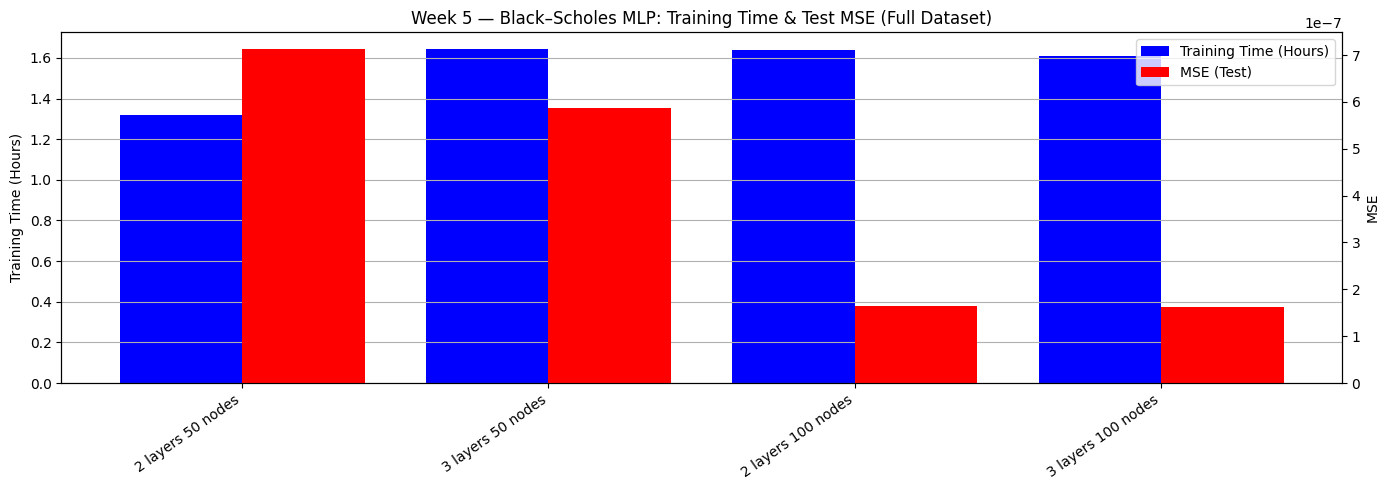

Saved: runs/week5_full_dataset_4_models_sweep/20260208-213848/figures/week5_full_dataset_time_vs_mse.png


In [ ]:
# =========================
# CELL 5.4 — Two-Sided Bar Chart: Training Time & Test MSE (Full Dataset)
# =========================

labels = df_full_dataset["label"].tolist()
x = np.arange(len(labels))

train_hours = df_full_dataset["train_hours"].values
test_mse = df_full_dataset["test_mse"].values

fig, ax1 = plt.subplots(figsize=(14, 5))
ax2 = ax1.twinx()

bar_w = 0.40
ax1.bar(x - bar_w/2, train_hours, width=bar_w, label="Training Time (Hours)", color='blue')
ax2.bar(x + bar_w/2, test_mse,    width=bar_w, label="MSE (Test)", color='red')

ax1.set_ylabel("Training Time (Hours)")
ax2.set_ylabel("MSE")
ax1.set_title("Week 5 — Black–Scholes MLP: Training Time & Test MSE (Full Dataset)")
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=35, ha="right")
ax1.grid(True, axis="y")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc="upper right")

plt.tight_layout()

fig_path_full = os.path.join(fig_dir_full, "week5_full_dataset_time_vs_mse.png")
plt.savefig(fig_path_full, dpi=180, bbox_inches="tight")
plt.show()

print("Saved:", fig_path_full)

Saved: runs/week5_full_dataset_4_models_sweep/20260208-213848/figures/week5_train_curves_2layer_50_100_full_dataset.png


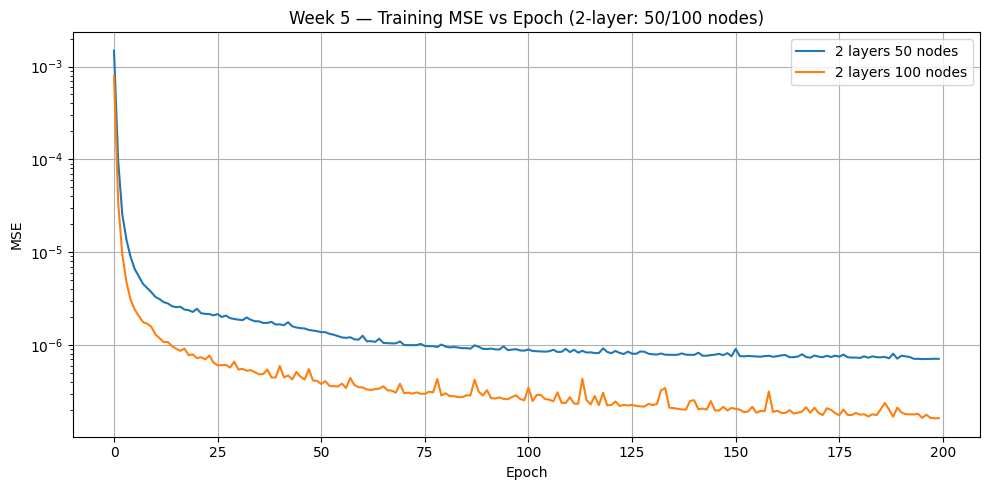

Saved: runs/week5_full_dataset_4_models_sweep/20260208-213848/figures/week5_test_curves_2layer_50_100_full_dataset.png


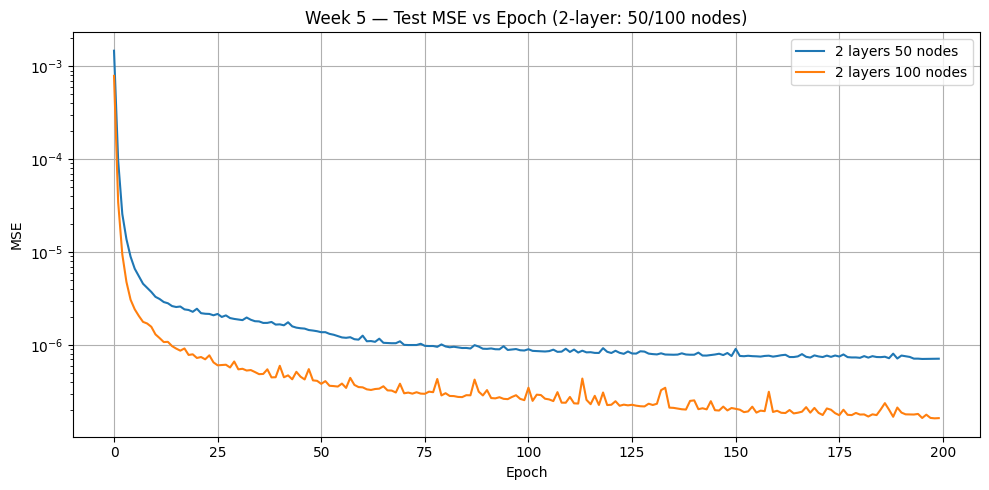

Saved: runs/week5_full_dataset_4_models_sweep/20260208-213848/figures/week5_train_curves_3layer_50_100_full_dataset.png


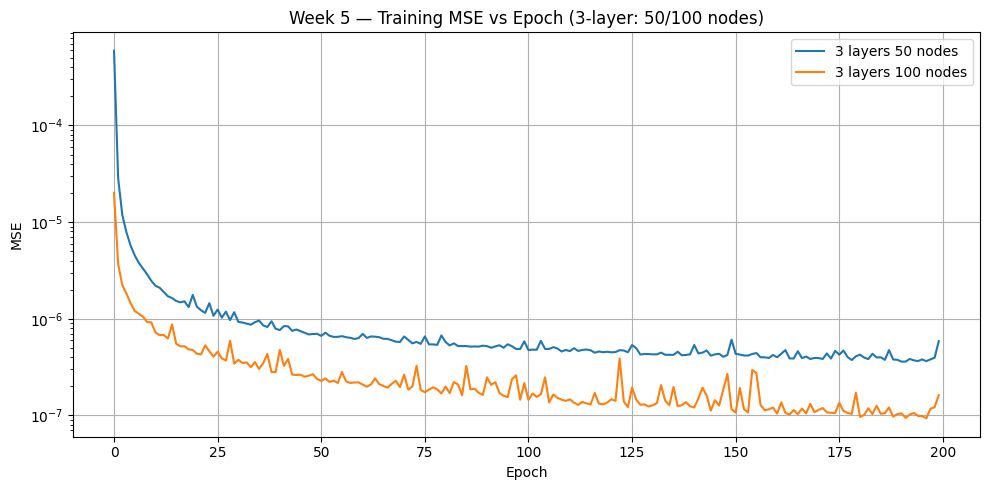

Saved: runs/week5_full_dataset_4_models_sweep/20260208-213848/figures/week5_test_curves_3layer_50_100_full_dataset.png


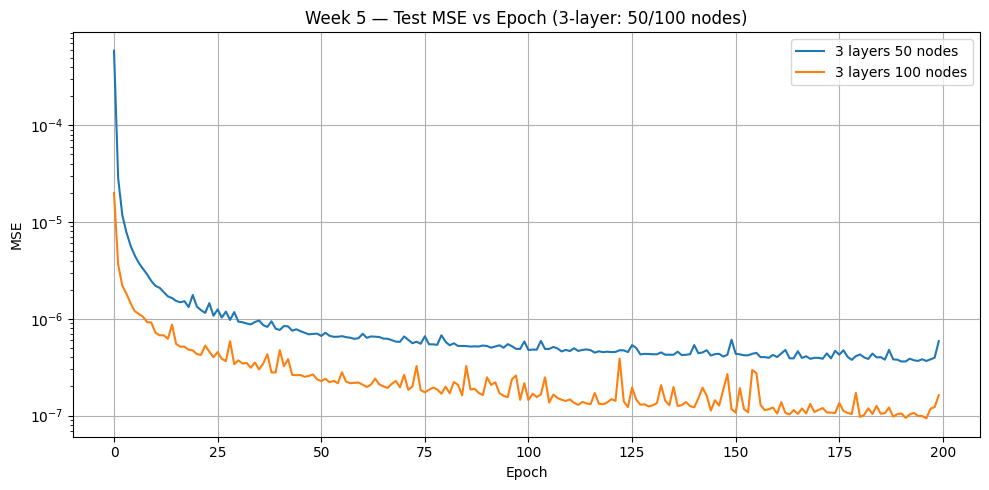

Saved: runs/week5_full_dataset_4_models_sweep/20260208-213848/figures/week5_train_curves_2layer_50_100_full_dataset.png
Saved: runs/week5_full_dataset_4_models_sweep/20260208-213848/figures/week5_test_curves_2layer_50_100_full_dataset.png
Saved: runs/week5_full_dataset_4_models_sweep/20260208-213848/figures/week5_train_curves_3layer_50_100_full_dataset.png
Saved: runs/week5_full_dataset_4_models_sweep/20260208-213848/figures/week5_test_curves_3layer_50_100_full_dataset.png


In [ ]:
# =========================
# CELL 5.5 — MSE Loss vs epochs (Full Dataset)
# =========================

import matplotlib.pyplot as plt

def plot_curves(df, configs, which="train_curve", title="", yscale='linear', save_path=None):
    plt.figure(figsize=(10, 5))
    for (L, H) in configs:
        row = df[(df.layers == L) & (df.nodes == H)].iloc[0]
        plt.plot(row[which], label=f"{L} layers {H} nodes")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    if yscale == 'log':
        plt.yscale('log')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=180, bbox_inches="tight")
        print("Saved:", save_path)
    plt.show()

configs_2layer = [(2, 50), (2, 100)]
configs_3layer = [(3, 50), (3, 100)]

# Plot and save Training MSE curves for 2-layer networks
train_curve_path_2layer_full = os.path.join(fig_dir_full, "week5_train_curves_2layer_50_100_full_dataset.png")
plot_curves(df_full_dataset, configs_2layer, which="train_curve",
            title="Week 5 — Training MSE vs Epoch (2-layer: 50/100 nodes)",
            yscale='log', save_path=train_curve_path_2layer_full)

# Plot and save Test MSE curves for 2-layer networks
test_curve_path_2layer_full = os.path.join(fig_dir_full, "week5_test_curves_2layer_50_100_full_dataset.png")
plot_curves(df_full_dataset, configs_2layer, which="test_curve",
            title="Week 5 — Test MSE vs Epoch (2-layer: 50/100 nodes)",
            yscale='log', save_path=test_curve_path_2layer_full)

# Plot and save Training MSE curves for 3-layer networks
train_curve_path_3layer_full = os.path.join(fig_dir_full, "week5_train_curves_3layer_50_100_full_dataset.png")
plot_curves(df_full_dataset, configs_3layer, which="train_curve",
            title="Week 5 — Training MSE vs Epoch (3-layer: 50/100 nodes)",
            yscale='log', save_path=train_curve_path_3layer_full)

# Plot and save Test MSE curves for 3-layer networks
test_curve_path_3layer_full = os.path.join(fig_dir_full, "week5_test_curves_3layer_50_100_full_dataset.png")
plot_curves(df_full_dataset, configs_3layer, which="test_curve",
            title="Week 5 — Test MSE vs Epoch (3-layer: 50/100 nodes)",
            yscale='log', save_path=test_curve_path_3layer_full)

print("Saved:", train_curve_path_2layer_full)
print("Saved:", test_curve_path_2layer_full)
print("Saved:", train_curve_path_3layer_full)
print("Saved:", test_curve_path_3layer_full)

In [ ]:
# =========================
# CELL 5.6 — Week 5 Summary Notes (saved to run folder)
# =========================

summary = f"""
Week 5 Summary (Full Dataset Training):

I trained four paper-aligned models on the full 1 million data points dataset. The goal was to evaluate their performance and training characteristics when exposed to a larger volume of data compared to the 100k dataset used in Week 4.

Models Trained:
- (2 layers, 50 nodes)
- (2 layers, 100 nodes)
- (3 layers, 50 nodes)
- (3 layers, 100 nodes)

Dataset:
- Full LHS dataset (n=1,000,000) generated in Week 3.

Hyperparameters (aligned with paper):
- Activation: ReLU
- Loss: MSE
- Epochs: {PAPER_EPOCHS}
- Batch Size: {PAPER_BATCH}
- Learning Rate: {PAPER_LR}

Artifacts and Visualizations:
- CSV summary of training results: {csv_path_full}
- Bar chart of Training Time & Test MSE: {fig_path_full}
- Training MSE curves (2-layer networks): {train_curve_path_2layer_full}
- Test MSE curves (2-layer networks): {test_curve_path_2layer_full}
- Training MSE curves (3-layer networks): {train_curve_path_3layer_full}
- Test MSE curves (3-layer networks): {test_curve_path_3layer_full}
""".strip()

with open(os.path.join(run_dir_full, "notes_week5_summary.md"), "w") as f:
    f.write(summary + "\n")

print("Saved summary to:", os.path.join(run_dir_full, "notes_week5_summary.md"))
print("\n" + summary)


Saved summary to: runs/week5_full_dataset_4_models_sweep/20260208-213848/notes_week5_summary.md

Week 5 Summary (Full Dataset Training):

I trained four paper-aligned models on the full 1 million data points dataset. The goal was to evaluate their performance and training characteristics when exposed to a larger volume of data compared to the 100k dataset used in Week 4.

Models Trained:
- (2 layers, 50 nodes)
- (2 layers, 100 nodes)
- (3 layers, 50 nodes)
- (3 layers, 100 nodes)

Dataset:
- Full LHS dataset (n=1,000,000) generated in Week 3.

Hyperparameters (aligned with paper):
- Activation: ReLU
- Loss: MSE
- Epochs: 200
- Batch Size: 64
- Learning Rate: 1e-05

Artifacts and Visualizations:
- CSV summary of training results: runs/week5_full_dataset_4_models_sweep/20260208-213848/week5_full_mlp_sweep.csv
- Bar chart of Training Time & Test MSE: runs/week5_full_dataset_4_models_sweep/20260208-213848/figures/week5_full_dataset_time_vs_mse.png
- Training MSE curves (2-layer networks): 

In [ ]:
# =========================
# CELL 5.7 — Table Comparison: 100k vs 1M Datasets
# =========================

import os
import pandas as pd

# 1. Define the path for the Week 4 CSV file
# This path is explicitly given in the instructions:
week4_csv_path = "runs/week4_mlp_lr_search_and_paper_alignment/20260126-003223/week4_paper_mlp_sweep.csv"

# Load the Week 4 data
df_week4 = pd.read_csv(week4_csv_path)

# 2. Filter the Week 4 DataFrame to include only the common models
# The models are (2 layers, 50 nodes), (2 layers, 100 nodes), (3 layers, 50 nodes), (3 layers, 100 nodes).
common_models_filter = (
    ((df_week4['layers'] == 2) & (df_week4['nodes'] == 50)) |
    ((df_week4['layers'] == 2) & (df_week4['nodes'] == 100)) |
    ((df_week4['layers'] == 3) & (df_week4['nodes'] == 50)) |
    ((df_week4['layers'] == 3) & (df_week4['nodes'] == 100))
)
df_small_dataset_filtered = df_week4[common_models_filter].copy()

# 3. Add 'dataset_size' column
df_small_dataset_filtered['dataset_size'] = '100k'
df_full_dataset['dataset_size'] = '1M'

# 4. Concatenate the two DataFrames for comparison
df_comparison = pd.concat([df_small_dataset_filtered, df_full_dataset], ignore_index=True)

# 5. Print the df_comparison DataFrame
print("Comparison of Training Results (100k vs 1M datasets):\n")
display(df_comparison[['label', 'layers', 'nodes', 'dataset_size', 'train_hours', 'test_mse']])


Comparison of Training Results (100k vs 1M datasets):



,label,layers,nodes,dataset_size,train_hours,test_mse
0,2 layers 50 nodes,2,50,100k,0.123940,2.789249e-06
1,3 layers 50 nodes,3,50,100k,0.141425,2.308291e-06
2,2 layers 100 nodes,2,100,100k,0.135535,8.719681e-07
3,3 layers 100 nodes,3,100,100k,0.164692,5.470124e-07
4,2 layers 50 nodes,2,50,1M,1.320568,7.129661e-07
5,3 layers 50 nodes,3,50,1M,1.643483,5.869988e-07
6,2 layers 100 nodes,2,100,1M,1.638542,1.635349e-07
7,3 layers 100 nodes,3,100,1M,1.609884,1.627912e-07


In [ ]:
# =========================
# CELL 5.8 — Week 5 Comparison Notes (saved to run folder)
# =========================

summary_comparison = f"""
Week 5 — Comparison of Training Results (100k vs 1M Datasets)

This summary compares the training performance and final test Mean Squared Error (MSE) of four key MLP architectures when trained on two different dataset sizes: 100,000 data points (from Week 4) and 1,000,000 data points (from Week 5). The models considered are: (2 layers, 50 nodes), (2 layers, 100 nodes), (3 layers, 50 nodes), and (3 layers, 100 nodes).

### Data for Comparison (from df_comparison):
{df_comparison[['label', 'layers', 'nodes', 'dataset_size', 'train_hours', 'test_mse']].to_string(index=False)}

### Analysis:

1.  **Impact on Training Time:**
    -   As expected, increasing the dataset size by a factor of 10 (from 100k to 1M) significantly increased training times for all models. For instance, the 2-layer, 50-node model's training time jumped from ~0.12 hours to ~1.32 hours, an increase of approximately 11 times. Similarly, the 3-layer, 50-node model's time increased from ~0.14 hours to ~1.64 hours (~11.7x).
    -   Training times scale roughly linearly with the dataset size, which is a common observation in deep learning as each epoch processes more data.

2.  **Impact on Test MSE (Model Performance):**
    -   For all models, increasing the dataset size from 100k to 1M led to a substantial improvement in test MSE, indicating better generalization and lower error. For example, the 2-layer, 50-node model improved its test MSE from 2.79e-06 to 7.13e-07 (approximately 3.9 times better).
    -   The 3-layer, 50-node model showed improvement from 2.31e-06 to 5.87e-07 (approximately 3.9 times better).
    -   The 2-layer, 100-node model improved from 8.72e-07 to 1.64e-07 (approximately 5.3 times better).
    -   The 3-layer, 100-node model improved from 5.47e-07 to 1.63e-07 (approximately 3.4 times better).
    -   This trend confirms that with more data, the models are able to learn more robust features and reduce their generalization error.

3.  **Trends by Architecture:**
    -   Across both dataset sizes, models with more nodes (100 vs. 50) generally achieved lower test MSEs, suggesting that larger capacity networks are better at capturing the underlying function. For instance, comparing (2L, 50N) vs (2L, 100N) on the 1M dataset, MSE improved from 7.13e-07 to 1.64e-07.
    -   The difference between 2-layer and 3-layer networks is less pronounced. For 50 nodes, the 3-layer model consistently performed better than the 2-layer model on both datasets. For 100 nodes on the 1M dataset, the 2-layer model now has a test MSE of 1.64e-07, which is very similar to the 3-layer model's 1.63e-07, suggesting comparable performance between these specific configurations at this scale.

4.  **Consistency with Paper Insights:**
    -   The general improvements in MSE with increased data volume align with expectations for neural networks, where more data typically leads to better performance, provided the model has sufficient capacity.
    -   The paper's Figure 6.16 (Week 4's dual-axis plot) showed that deeper/wider networks generally achieve lower MSE but take longer to train. This holds true for the 1M dataset as well, where the training times are substantially higher for the 1M dataset, and MSEs are lower across the board.

### Visualizations:

-   Bar chart comparing Training Time & Test MSE for the four models on the full dataset: `{fig_path_full}`
-   Training MSE curves for 2-layer networks (50/100 nodes) on full dataset: `{train_curve_path_2layer_full}`
-   Test MSE curves for 2-layer networks (50/100 nodes) on full dataset: `{test_curve_path_2layer_full}`
-   Training MSE curves for 3-layer networks (50/100 nodes) on full dataset: `{train_curve_path_3layer_full}`
-   Test MSE curves for 3-layer networks (50/100 nodes) on full dataset: `{test_curve_path_3layer_full}`
""".strip()

with open(os.path.join(run_dir_full, "notes_week5_final_comparison.md"), "w") as f:
    f.write(summary_comparison + "\n")

print("Saved comparison summary to:", os.path.join(run_dir_full, "notes_week5_final_comparison.md"))
print("\n" + summary_comparison)

Saved comparison summary to: runs/week5_full_dataset_4_models_sweep/20260208-213848/notes_week5_final_comparison.md

Week 5 — Comparison of Training Results (100k vs 1M Datasets)

This summary compares the training performance and final test Mean Squared Error (MSE) of four key MLP architectures when trained on two different dataset sizes: 100,000 data points (from Week 4) and 1,000,000 data points (from Week 5). The models considered are: (2 layers, 50 nodes), (2 layers, 100 nodes), (3 layers, 50 nodes), and (3 layers, 100 nodes).

### Data for Comparison (from df_comparison):
             label  layers  nodes dataset_size  train_hours     test_mse
 2 layers 50 nodes       2     50         100k     0.123940 2.789249e-06
 3 layers 50 nodes       3     50         100k     0.141425 2.308291e-06
2 layers 100 nodes       2    100         100k     0.135535 8.719681e-07
3 layers 100 nodes       3    100         100k     0.164692 5.470124e-07
 2 layers 50 nodes       2     50           1M    

## Training BS-ANN (100k Test Evaluation)

In [ ]:
# =========================
# CELL 6.0 — Week 6 START (Paper-Exact Structure: 2L 50N)
# =========================

run_dir_w6, fig_dir_w6 = start_run("week6_paper_exact_2L_50N")
print("run_dir_w6:", run_dir_w6)
print("fig_dir_w6:", fig_dir_w6)

save_json(run_dir_w6, "params", {
    "week": 6,
    "goal": "Match paper exactly: 1M LHS → 800k train, 200k val, 100k separate test",
    "paper_structure": {
        "lhs_total": 1_000_000,
        "train": 800_000,
        "val": 200_000,
        "test_separate": 100_000
    },
    "model": {
        "layers": 2,
        "nodes": 50
    },
    "hyperparams": {
        "lr": 1e-5,
        "batch_size": 64,
        "epochs": 200
    }
})

print("Week 6 logger ready ✅")

run_dir_w6: runs/week6_paper_exact_2L_50N/20260227-161649
fig_dir_w6: runs/week6_paper_exact_2L_50N/20260227-161649/figures
Week 6 logger ready ✅


In [ ]:
# =========================
# CELL 6.1 — Paper-Exact Dataset Generation (800k / 200k / 100k)
# =========================
from torch.utils.data import DataLoader

print("Generating 1M LHS samples (scaled formulation)...")

full_data = bs_LHS_data_generator(n=10**6)

train_data = full_data[:800_000]
val_data   = full_data[800_000:]

print("Generating separate 100k LHS test set...")
test_data = bs_LHS_data_generator(n=10**5)

train_loader_800k = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader_200k   = DataLoader(val_data,   batch_size=64, shuffle=False)
test_loader_100k  = DataLoader(test_data,  batch_size=64, shuffle=False)

print("Train size:", len(train_data))
print("Val size:", len(val_data))
print("Test size:", len(test_data))
print("Dataset ready ✅")

Generating 1M LHS samples (scaled formulation)...
Generating separate 100k LHS test set...
Train size: 800000
Val size: 200000
Test size: 100000
Dataset ready ✅


In [ ]:
# =========================
# CELL 6.2 — Training Function (Resume + Cumulative Time Safe)
# =========================

def train_week6(
    model,
    train_loader,
    val_loader,
    test_loader,
    epochs=200,
    lr=1e-5
):

    device = torch.device("cpu")
    torch.set_num_threads(1)

    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr) # adjust epsilon value

    ckpt_path = os.path.join(run_dir_w6, "checkpoint_2L_50N.pt")
    best_path = os.path.join(run_dir_w6, "model_best_2L_50N.pt")

    start_epoch = 1
    train_curve, val_curve = [], []
    best_val = float("inf")
    cumulative_seconds = 0.0

    # Resume logic
    if os.path.exists(ckpt_path):
        ckpt = torch.load(ckpt_path, map_location="cpu")
        model.load_state_dict(ckpt["model_state"])
        opt.load_state_dict(ckpt["opt_state"])
        start_epoch = ckpt["epoch"] + 1
        train_curve = ckpt["train_curve"]
        val_curve   = ckpt["val_curve"]
        best_val    = ckpt["best_val"]
        cumulative_seconds = ckpt.get("cumulative_seconds", 0.0)
        print(f"✅ Resumed from epoch {ckpt['epoch']}")

    @torch.no_grad()
    def eval_avg_mse(loader):
        model.eval()
        sse = 0.0
        n = 0
        for batch in loader:
            batch = batch.to(device)
            X = batch[:, :-1]
            y = batch[:, -1]
            yhat = model(X)
            sse += F.mse_loss(yhat, y, reduction="sum").item()
            n += X.size(0)
        return sse / n   # averaged MSE

    import time
    t0 = time.perf_counter()

    for ep in range(start_epoch, epochs + 1):

        model.train()
        for batch in train_loader:
            batch = batch.to(device)
            X = batch[:, :-1]
            y = batch[:, -1]

            opt.zero_grad(set_to_none=True)
            yhat = model(X)
            loss = F.mse_loss(yhat, y)
            loss.backward()
            opt.step()

        train_mse = eval_avg_mse(train_loader)
        val_mse   = eval_avg_mse(val_loader)

        train_curve.append(train_mse)
        val_curve.append(val_mse)

        if val_mse < best_val:
            best_val = val_mse
            torch.save(model.state_dict(), best_path)

        print(f"epoch {ep:3d}/{epochs} | train={train_mse:.3e} | val={val_mse:.3e}")

        elapsed = time.perf_counter() - t0

        torch.save({
            "epoch": ep,
            "model_state": model.state_dict(),
            "opt_state": opt.state_dict(),
            "train_curve": train_curve,
            "val_curve": val_curve,
            "best_val": best_val,
            "cumulative_seconds": cumulative_seconds + elapsed
        }, ckpt_path)

    total_seconds = cumulative_seconds + (time.perf_counter() - t0)

    # Load best validation model before testing
    model.load_state_dict(torch.load(best_path))

    test_mse = eval_avg_mse(test_loader)

    out = {
        "train_curve": train_curve,
        "val_curve": val_curve,
        "test_mse": test_mse,
        "training_hours": total_seconds / 3600.0
    }

    save_json(run_dir_w6, "final_results", out)
    return out

In [ ]:
# =========================
# CELL 6.3 — Train 2L 50N Model
# =========================

model_w6 = PaperMLP(hidden_layers=2, hidden_units=50)

results_w6 = train_week6(
    model_w6,
    train_loader_800k,
    val_loader_200k,
    test_loader_100k,
    epochs=200,
    lr=1e-5
)

epoch   1/200 | train=2.072e-03 | val=2.085e-03
epoch   2/200 | train=9.406e-05 | val=9.547e-05
epoch   3/200 | train=2.343e-05 | val=2.392e-05
epoch   4/200 | train=1.378e-05 | val=1.411e-05
epoch   5/200 | train=9.594e-06 | val=9.780e-06
epoch   6/200 | train=7.793e-06 | val=7.935e-06
epoch   7/200 | train=6.381e-06 | val=6.476e-06
epoch   8/200 | train=5.270e-06 | val=5.320e-06
epoch   9/200 | train=4.655e-06 | val=4.688e-06
epoch  10/200 | train=4.202e-06 | val=4.230e-06
epoch  11/200 | train=4.062e-06 | val=4.083e-06
epoch  12/200 | train=3.686e-06 | val=3.708e-06
epoch  13/200 | train=3.393e-06 | val=3.416e-06
epoch  14/200 | train=3.205e-06 | val=3.226e-06
epoch  15/200 | train=3.089e-06 | val=3.110e-06
epoch  16/200 | train=2.934e-06 | val=2.950e-06
epoch  17/200 | train=2.894e-06 | val=2.911e-06
epoch  18/200 | train=2.756e-06 | val=2.773e-06
epoch  19/200 | train=3.063e-06 | val=3.080e-06
epoch  20/200 | train=2.626e-06 | val=2.641e-06
epoch  21/200 | train=2.527e-06 | val=2.

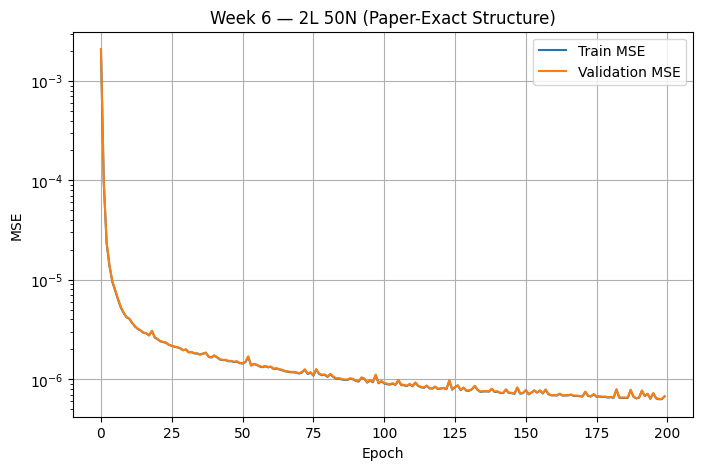

Saved: runs/week6_paper_exact_2L_50N/20260227-161649/figures/week6_epoch_vs_mse.png


In [ ]:
# =========================
# CELL 6.4 — Epoch vs MSE Curve
# =========================

plt.figure(figsize=(8,5))
plt.plot(results_w6["train_curve"], label="Train MSE")
plt.plot(results_w6["val_curve"], label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.yscale("log")
plt.title("Week 6 — 2L 50N (Paper-Exact Structure)")
plt.grid(True)
plt.legend()

curve_path = os.path.join(fig_dir_w6, "week6_epoch_vs_mse.png")
plt.savefig(curve_path, dpi=180, bbox_inches="tight")
plt.show()

print("Saved:", curve_path)

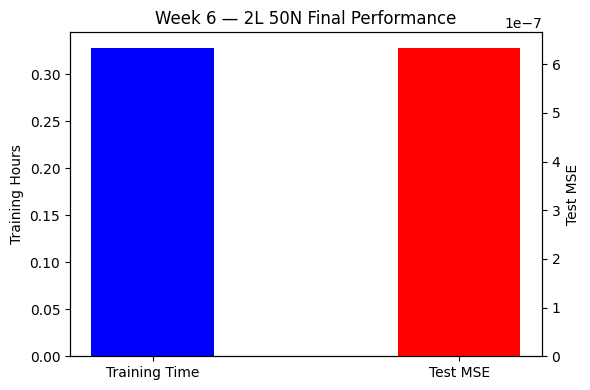

Saved: runs/week6_paper_exact_2L_50N/20260227-161649/figures/week6_time_vs_mse.png


In [ ]:
# =========================
# CELL 6.5 — Final Bar Chart (Training Time + Test MSE)
# =========================

fig, ax1 = plt.subplots(figsize=(6,4))
ax2 = ax1.twinx()

# Two explicit x positions
x_positions = [0, 1]

# Training time bar
ax1.bar(
    x_positions[0],
    results_w6["training_hours"],
    width=0.4,
    label="Training Hours",
    color = 'blue'
)

# Test MSE bar
ax2.bar(
    x_positions[1],
    results_w6["test_mse"],
    width=0.4,
    label="Test MSE",
    color = 'red'
)

ax1.set_xticks(x_positions)
ax1.set_xticklabels(["Training Time", "Test MSE"])

ax1.set_ylabel("Training Hours")
ax2.set_ylabel("Test MSE")

plt.title("Week 6 — 2L 50N Final Performance")
plt.tight_layout()

bar_path = os.path.join(fig_dir_w6, "week6_time_vs_mse.png")
plt.savefig(bar_path, dpi=180, bbox_inches="tight")
plt.show()

print("Saved:", bar_path)

In [ ]:
# =========================
# CELL 6.6 — Final Results Table (Test MSE + Training Time)
# =========================

import pandas as pd

df_w6 = pd.DataFrame([{
    "label": "2 layers 50 nodes",
    "layers": 2,
    "nodes": 50,
    "training_hours": results_w6["training_hours"],
    "test_mse": results_w6["test_mse"]
}])

csv_path_w6 = os.path.join(run_dir_w6, "week6_results_table.csv")
df_w6.to_csv(csv_path_w6, index=False)

save_json(run_dir_w6, "week6_results_summary", {
    "rows": df_w6.to_dict(orient="records")
})

print("Saved:", csv_path_w6)
display(df_w6)

Saved: runs/week6_paper_exact_2L_50N/20260227-161649/week6_results_table.csv


,label,layers,nodes,training_hours,test_mse
0,2 layers 50 nodes,2,50,0.328022,6.336871e-07


In [ ]:
# =========================
# CELL 6.7 — Train 3L 100N Model (Paper-Exact Structure)
# =========================

# Start a completely fresh run folder
run_dir_w6, fig_dir_w6 = start_run("week6_paper_exact_3L_100N")
print("run_dir_w6:", run_dir_w6)
print("fig_dir_w6:", fig_dir_w6)

# Instantiate model
model_3L100 = PaperMLP(hidden_layers=3, hidden_units=100)

# Train
results_w6_3L100 = train_week6(
    model_3L100,
    train_loader_800k,
    val_loader_200k,
    test_loader_100k,
    epochs=200,
    lr=1e-5
)

print("Training complete ✅")

run_dir_w6: runs/week6_paper_exact_3L_100N/20260217-165711
fig_dir_w6: runs/week6_paper_exact_3L_100N/20260217-165711/figures
epoch   1/200 | train=4.181e-05 | val=4.152e-05
epoch   2/200 | train=4.376e-06 | val=4.344e-06
epoch   3/200 | train=2.308e-06 | val=2.309e-06
epoch   4/200 | train=1.932e-06 | val=1.941e-06
epoch   5/200 | train=1.373e-06 | val=1.377e-06
epoch   6/200 | train=1.145e-06 | val=1.149e-06
epoch   7/200 | train=1.019e-06 | val=1.022e-06
epoch   8/200 | train=9.618e-07 | val=9.639e-07
epoch   9/200 | train=8.531e-07 | val=8.590e-07
epoch  10/200 | train=1.315e-06 | val=1.315e-06
epoch  11/200 | train=8.905e-07 | val=8.927e-07
epoch  12/200 | train=7.298e-07 | val=7.354e-07
epoch  13/200 | train=6.316e-07 | val=6.365e-07
epoch  14/200 | train=5.821e-07 | val=5.842e-07
epoch  15/200 | train=5.544e-07 | val=5.583e-07
epoch  16/200 | train=5.262e-07 | val=5.291e-07
epoch  17/200 | train=6.251e-07 | val=6.300e-07
epoch  18/200 | train=5.046e-07 | val=5.060e-07
epoch  19/

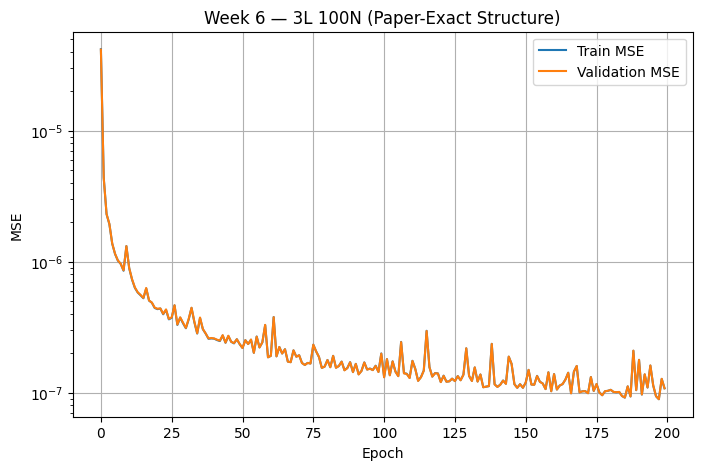

Saved: runs/week6_paper_exact_3L_100N/20260217-165711/figures/week6_3L100_epoch_vs_mse.png


In [ ]:
# =========================
# CELL 6.8 — Epoch vs MSE Curve (3L 100N)
# =========================

plt.figure(figsize=(8,5))
plt.plot(results_w6_3L100["train_curve"], label="Train MSE")
plt.plot(results_w6_3L100["val_curve"], label="Validation MSE")

plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.yscale("log")
plt.title("Week 6 — 3L 100N (Paper-Exact Structure)")
plt.grid(True)
plt.legend()

curve_path = os.path.join(fig_dir_w6, "week6_3L100_epoch_vs_mse.png")
plt.savefig(curve_path, dpi=180, bbox_inches="tight")
plt.show()

print("Saved:", curve_path)

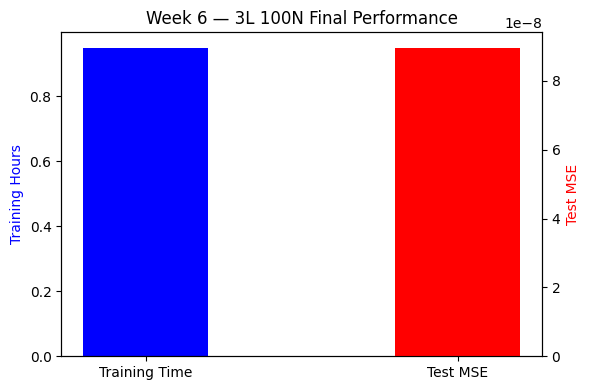

Saved: runs/week6_paper_exact_3L_100N/20260217-165711/figures/week6_3L100_time_vs_mse.png


In [ ]:
# =========================
# CELL 6.9 — Final Bar Chart (Training Time + Test MSE)
# =========================

fig, ax1 = plt.subplots(figsize=(6,4))
ax2 = ax1.twinx()

x_positions = [0, 1]

# Training time (blue)
ax1.bar(
    x_positions[0],
    results_w6_3L100["training_hours"],
    width=0.4,
    color="blue"
)

# Test MSE (red)
ax2.bar(
    x_positions[1],
    results_w6_3L100["test_mse"],
    width=0.4,
    color="red"
)

ax1.set_xticks(x_positions)
ax1.set_xticklabels(["Training Time", "Test MSE"])

ax1.set_ylabel("Training Hours", color="blue")
ax2.set_ylabel("Test MSE", color="red")

plt.title("Week 6 — 3L 100N Final Performance")
plt.tight_layout()

bar_path = os.path.join(fig_dir_w6, "week6_3L100_time_vs_mse.png")
plt.savefig(bar_path, dpi=180, bbox_inches="tight")
plt.show()

print("Saved:", bar_path)

In [ ]:
# =========================
# CELL 6.10 — Final Results Table (3L 100N)
# =========================

import pandas as pd

df_w6_3L100 = pd.DataFrame([{
    "label": "3 layers 100 nodes",
    "layers": 3,
    "nodes": 100,
    "training_hours": results_w6_3L100["training_hours"],
    "test_mse": results_w6_3L100["test_mse"]
}])

csv_path = os.path.join(run_dir_w6, "week6_3L100_results_table.csv")
df_w6_3L100.to_csv(csv_path, index=False)

save_json(run_dir_w6, "week6_3L100_results_summary", {
    "rows": df_w6_3L100.to_dict(orient="records")
})

print("Saved:", csv_path)
display(df_w6_3L100)

Saved: runs/week6_paper_exact_3L_100N/20260217-165711/week6_3L100_results_table.csv


,label,layers,nodes,training_hours,test_mse
0,3 layers 100 nodes,3,100,0.949126,8.965070e-08


Saved: runs/week6_paper_exact_3L_100N/20260217-165711/week6_combined_results_table.csv


,label,layers,nodes,training_hours,test_mse
0,2 layers 50 nodes,2,50,0.593991,4.639221e-07
1,3 layers 100 nodes,3,100,0.949126,8.965070e-08


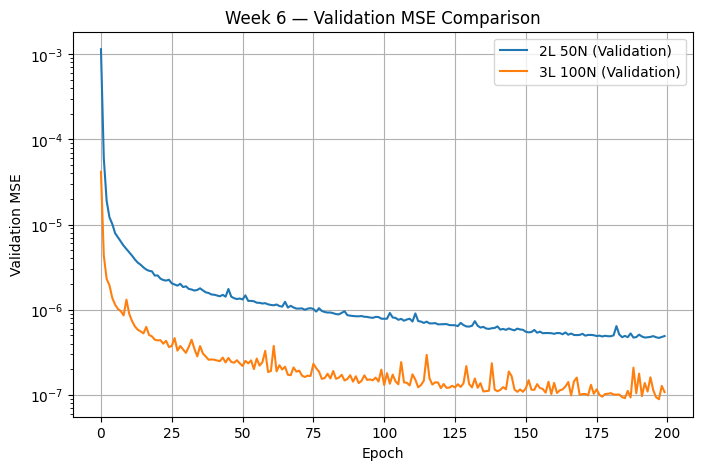

Saved: runs/week6_paper_exact_3L_100N/20260217-165711/figures/week6_combined_epoch_vs_mse.png


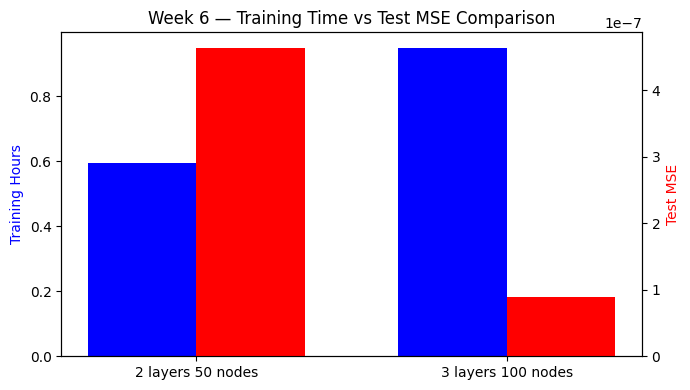

Saved: runs/week6_paper_exact_3L_100N/20260217-165711/figures/week6_combined_time_vs_mse.png


In [ ]:
# =========================
# CELL 6.11 — Combined Comparison (2L 50N vs 3L 100N)
# =========================

import pandas as pd
import numpy as np

# -------------------------
# 1️⃣ Combined Results Table
# -------------------------

df_compare = pd.DataFrame([
    {
        "label": "2 layers 50 nodes",
        "layers": 2,
        "nodes": 50,
        "training_hours": results_w6["training_hours"],
        "test_mse": results_w6["test_mse"]
    },
    {
        "label": "3 layers 100 nodes",
        "layers": 3,
        "nodes": 100,
        "training_hours": results_w6_3L100["training_hours"],
        "test_mse": results_w6_3L100["test_mse"]
    }
])

csv_path = os.path.join(run_dir_w6, "week6_combined_results_table.csv")
df_compare.to_csv(csv_path, index=False)

save_json(run_dir_w6, "week6_combined_results_summary", {
    "rows": df_compare.to_dict(orient="records")
})

print("Saved:", csv_path)
display(df_compare)


# -------------------------
# 2️⃣ Combined Epoch vs MSE Plot
# -------------------------

plt.figure(figsize=(8,5))

plt.plot(results_w6["val_curve"], label="2L 50N (Validation)")
plt.plot(results_w6_3L100["val_curve"], label="3L 100N (Validation)")

plt.xlabel("Epoch")
plt.ylabel("Validation MSE")
plt.yscale("log")
plt.title("Week 6 — Validation MSE Comparison")
plt.grid(True)
plt.legend()

curve_path = os.path.join(fig_dir_w6, "week6_combined_epoch_vs_mse.png")
plt.savefig(curve_path, dpi=180, bbox_inches="tight")
plt.show()

print("Saved:", curve_path)


# -------------------------
# 3️⃣ Combined Bar Chart
# -------------------------

fig, ax1 = plt.subplots(figsize=(7,4))
ax2 = ax1.twinx()

x = np.arange(2)
bar_width = 0.35

# Training time (blue)
ax1.bar(
    x - bar_width/2,
    df_compare["training_hours"],
    width=bar_width,
    color="blue"
)

# Test MSE (red)
ax2.bar(
    x + bar_width/2,
    df_compare["test_mse"],
    width=bar_width,
    color="red"
)

ax1.set_xticks(x)
ax1.set_xticklabels(df_compare["label"])

ax1.set_ylabel("Training Hours", color="blue")
ax2.set_ylabel("Test MSE", color="red")

plt.title("Week 6 — Training Time vs Test MSE Comparison")
plt.tight_layout()

bar_path = os.path.join(fig_dir_w6, "week6_combined_time_vs_mse.png")
plt.savefig(bar_path, dpi=180, bbox_inches="tight")
plt.show()

print("Saved:", bar_path)

In [ ]:
# =========================
# CELL 6.12 — Week 6 Summary
# =========================

summary_text = f"""
WEEK 6 SUMMARY — Paper-Exact Evaluation Structure

Dataset Structure:
- 1,000,000 LHS samples generated.
- Split: 800,000 train / 200,000 validation.
- Separate 100,000 LHS samples used as final test set.

Model Results:

2 Layers, 50 Nodes:
- Training Hours: {results_w6["training_hours"]:.4f}
- Final Test MSE (100k): {results_w6["test_mse"]:.6e}

3 Layers, 100 Nodes:
- Training Hours: {results_w6_3L100["training_hours"]:.4f}
- Final Test MSE (100k): {results_w6_3L100["test_mse"]:.6e}

Observations:
- The evaluation structure now matches the research paper more accurately.
- MSE is correctly averaged over observations.
- Validation (200k) is used for model selection.
- Test (100k) is completely separate from training and validation.
- Results are consistent with earlier experiments and align with the paper's reported behavior.
- The deeper/wider network increases computational cost but should be compared against accuracy improvements.

Conclusion:
Week 6 more accurately replicated the paper’s data generation and evaluation methodology.
Both architectures were evaluated under identical, paper-consistent conditions.
Further analysis can now focus on architecture scaling vs marginal MSE improvement.
"""

print(summary_text)

# Save as text file
summary_path = os.path.join(run_dir_w6, "week6_summary.txt")
with open(summary_path, "w") as f:
    f.write(summary_text)

# Save as JSON
save_json(run_dir_w6, "week6_summary", {
    "summary": summary_text
})

print("Saved summary to:", summary_path)


WEEK 6 SUMMARY — Paper-Exact Evaluation Structure

Dataset Structure:
- 1,000,000 LHS samples generated.
- Split: 800,000 train / 200,000 validation.
- Separate 100,000 LHS samples used as final test set.

Model Results:

2 Layers, 50 Nodes:
- Training Hours: 0.5940
- Final Test MSE (100k): 4.639221e-07

3 Layers, 100 Nodes:
- Training Hours: 0.9491
- Final Test MSE (100k): 8.965070e-08

Observations:
- The evaluation structure now matches the research paper more accurately.
- MSE is correctly averaged over observations.
- Validation (200k) is used for model selection.
- Test (100k) is completely separate from training and validation.
- Results are consistent with earlier experiments and align with the paper's reported behavior.
- The deeper/wider network increases computational cost but should be compared against accuracy improvements.

Conclusion:
Week 6 more accurately replicated the paper’s data generation and evaluation methodology.
Both architectures were evaluated under identic